# Importing Dataset and setting the working Directory

In [1]:
from os import chdir
chdir('/Users/sourabhdabke/Documents/ETL_Hive/Python/Week_22/Proj5/')
import pandas as pd
A = pd.read_csv('HR-Employee-Attrition.csv')
from pandas import set_option
set_option('display.max_columns',50)
set_option('display.max_rows',600)
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
A.head(2)

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,0,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7


### Missing Data Treatment

In [3]:
#A.isna().sum()

No missing Data was detected

## Converting Continuous Attrition to Categorical

In [4]:
q = []
for i in A.Attrition:
    if i == 1:
        q.append('Left')
    else:
        q.append('Not Left')
A = A.drop(labels=['Attrition'],axis = 1)
A['Attrition'] = q

### Unwanted columns

In [5]:
#A.nunique()

1. EmployeeCount 
2. EmployeeNumber 
3. Over18 
4. StandardHours

In [6]:
A = A.drop(labels=['EmployeeCount','EmployeeNumber','StandardHours','Over18'],axis = 1)

### Check skew

In [7]:
#A.skew()

No significatn skew was detected, so by-passing this step

## Standard Scalar model for the entire dataset

In [8]:
con = []
for i in A.columns:
    if A[i].dtypes != 'object':
        con.append(i)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(A[con])

StandardScaler()

## Outlier Analysis

In [9]:
cat = []
con = []
for i in A.columns:
    if A[i].dtypes == 'object':
        cat.append(i)
    else:
        con.append(i)
        
A1 = pd.get_dummies(A[cat])
A2 = pd.DataFrame(ss.transform(A[con]),columns=con)
Anew = A2.join(A1)

outliers = []
for i in con:
    outliers.extend(list(Anew[Anew[i] > 3].index))
    outliers.extend(list(Anew[Anew[i] < -3].index))    
from numpy import unique
list(unique(outliers))
len(list(unique(outliers)))

83

### Dropping Outliers from A

In [10]:
A = A.drop(index=outliers,axis = 0)
A.index = range(0,A.shape[0])

# Perform Regression treating Monthly Rate as Y, and choose prediction error and the best model
Use Simple Linear Regression, Multiple Linear Regression, Ridge Regression, Lasso, Random Forest,AdaBoost,Decision Tree

#### Skew

In [617]:
#A.skew()

no significant skew was seen so no correction is required

###### For SLR MLR Ridge Lass we need to find important columns using ANOVA and correlation tests

Correlation to find import continuous columns

In [613]:
q = A.corr()[['MonthlyRate']].sort_values(by=['MonthlyRate'])

In [615]:
imp_con_col = q[(q > 0.4) & (q < 1)].index

ANOVA to find important cat columns

In [ ]:
def ANOVA(df,cat,con):
    rel = con + '~' + cat
    from statsmodels.formula.api import ols
    model = old(df,rel).fit()
    from statsmodels.stats.anova import anova_lm
    anova_results = anova_lm(model)
    return round(anova_results.iloc[0,4],4)

In [629]:
def ANOVA(df,cat,con):
    from statsmodels.formula.api import ols
    rel = con + '~' + cat
    model = ols(rel,df).fit()
    from statsmodels.stats.anova import anova_lm
    anova_results = anova_lm(model)
    return round(anova_results.iloc[0,4],4)

In [630]:
cat = []
con = []
for i in A.columns:
    if A[i].dtypes == 'object':
        cat.append(i)
    else:
        con.append(i)

In [634]:
for i in cat:
    print('----------')
    w = ANOVA(A,i,'MonthlyRate')
    print('Monthly Rate vs',i)
    print(w)

----------
Monthly Rate vs BusinessTravel
0.9051
----------
Monthly Rate vs Department
0.6245
----------
Monthly Rate vs EducationField
0.7118
----------
Monthly Rate vs Gender
0.0878
----------
Monthly Rate vs JobRole
0.5275
----------
Monthly Rate vs MaritalStatus
0.1766
----------
Monthly Rate vs OverTime
0.8363
----------
Monthly Rate vs Attrition
0.5796


from ANOVA we can see the least important cat columns are Gender and MartialStatus

In [657]:
imp_cat_col = ['Gender','MaritalStatus']

In [658]:
imp_con_col = list(imp_con_col)

In [659]:
imp_col = imp_con_col + imp_cat_col

# Dividing the data in X and Y for analysis

In [797]:
X = A[imp_col]
X = X.drop(labels=['MonthlyRate'],axis = 1)
Y = A[['MonthlyRate']]

## Preprocessing

#### StandardScalar for regression

In [798]:
con = []
for i in X.columns:
    if X[i].dtypes != 'object':
        con.append(i)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X[con])

StandardScaler()

In [799]:
cat = []
con = []
for i in X.columns:
    if X[i].dtypes == 'object':
        cat.append(i)
    else:
        con.append(i)
        
X1 = pd.get_dummies(X[cat])

X2 = pd.DataFrame(ss.transform(X[con]),columns=con)

Xnew = X2.join(X1)

# Backward Elimination Model

In [800]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)

from statsmodels.api import OLS,add_constant
xconst = add_constant(xtrain)

ols = OLS(ytrain,xconst)

model = ols.fit()
round(model.rsquared_adj,10)

3.846e-05

In [801]:
p = model.pvalues
q = model.pvalues.max()
col_to_drop = list(p[p == q].index)[0]

In [802]:
Xnew = Xnew.drop(labels=col_to_drop,axis = 1)
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)

from statsmodels.api import OLS,add_constant
xconst = add_constant(xtrain)

ols = OLS(ytrain,xconst)

model = ols.fit()
round(model.rsquared_adj,6)

0.000961

In [823]:
p = model.pvalues
q = model.pvalues.max()
col_to_drop = list(p[p == q].index)[0]

Xnew = Xnew.drop(labels=col_to_drop,axis = 1)
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)

from statsmodels.api import OLS,add_constant
xconst = add_constant(xtrain)

ols = OLS(ytrain,xconst)

model = ols.fit()
round(model.rsquared_adj,6)

0.004184

In [821]:
Xnew1 = Xnew

In [824]:
Xnew = Xnew1

In [825]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)

from statsmodels.api import OLS,add_constant
xconst = add_constant(xtrain)

ols = OLS(ytrain,xconst)

model = ols.fit()
round(model.rsquared_adj,6)

0.012556

In [826]:
Xnew.columns

Index(['YearsAtCompany', 'JobInvolvement', 'JobLevel', 'Gender_Female',
       'Gender_Male', 'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single'],
      dtype='object')

From Backward Elimination we get the best adjusted r value as 0.012556 for columns in: <br>
X --> YearsAtCompany, &nbsp; JobInvolvement, &nbsp;JobLevel, &nbsp;Gender_Female, &nbsp;Gender_Male, MaritalStatus_Divorced,&nbsp; MaritalStatus_Married, &nbsp;MaritalStatus_Single

## Creating Linear Model to check error

In [830]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

model = lr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5990.954914337241
Testing Error : 6471.586330935252


### Ridge and Lasso to improve the model

Creating Tuning Grid

In [842]:
val_to_try = []
x=1
for i in range(0,50):
    x = x + 0.001
    val_to_try.append(round(x,3))
                      
x = 1
for i in range(0,50):
    x = x - 0.001
    val_to_try.append(round(x,3))
    
tg = {'alpha':val_to_try}

# Finiding best parameters for Ridge and Lasso Regression

Ridge

In [843]:
from sklearn.linear_model import Ridge
rr = Ridge()

from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rr,tg,scoring='neg_mean_absolute_error',cv = 4)

cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'alpha': 1.05}

Lasso

In [844]:
from sklearn.linear_model import Lasso
lr = Lasso()

from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(lr,tg,scoring='neg_mean_absolute_error',cv = 4)

cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'alpha': 0.953}

# Ridge Regression Model

In [845]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha=1.05)

model = rr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5985.226946896379
Testing Error : 6471.327877981215


# Lasso Regression Model

In [848]:
from sklearn.linear_model import Lasso
lr = Lasso(alpha=0.953)

model = lr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5985.247995404653
Testing Error : 6471.279255088766


### So Best model is for Lasso Regression with error values: 
    Training Error : 5985.247995404653
    Testing Error : 6471.279255088766

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

## Model Creation with Decision Tree, RandomForest and AdaBoost methods :
    for tree we do not need to find important columns also only OHE for categorical is required, so let us take the entire original dataset A and create model on it

Dividing Dataset in X and Y

In [852]:
Y = A[['MonthlyRate']]
X = A.drop(labels=['MonthlyRate'],axis =1)

In [854]:
cat = []
con = []

for i in X.columns:
    if X[i].dtypes == 'object':
        cat.append(i)
    else:
        con.append(i)
        
X1 = pd.get_dummies(X[cat])
X2 = X[con]

Xnew = X2.join(X1)

## Decision Tree Model

In [855]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)

In [882]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=31)

model = dtr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 0.0
Testing Error : 8778.03237410072


## DT with max depth

In [881]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=31,max_depth=2)

model = dtr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5922.84513703303
Testing Error : 6364.118120620322


In [880]:
tg = {'max_depth':range(2,10)}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
cv = GridSearchCV(dtr,tg,scoring ='neg_mean_absolute_error',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'max_depth': 2}

### With criterion absolute error

In [908]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=31,max_depth=2,criterion='absolute_error')

model = dtr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5903.501352569882
Testing Error : 6399.46762589928


## DT with Min sample split

In [890]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=31,min_samples_split=253)

model = dtr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5783.335262662189
Testing Error : 6494.449775671064


In [885]:
tg = {'min_samples_split':range(2,275)}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=31)
cv = GridSearchCV(dtr,tg,scoring ='neg_mean_absolute_error',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'min_samples_split': 253}

### With criterion absolute error

In [910]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=31,min_samples_split=253,criterion='absolute_error')

model = dtr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5666.482416591524
Testing Error : 6517.830935251798


## DT with min sample leaf

In [893]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=31,min_samples_leaf=222)

model = dtr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5941.946004366742
Testing Error : 6402.7533413365


In [894]:
tg = {'min_samples_leaf':range(2,375)}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=31)
cv = GridSearchCV(dtr,tg,scoring ='neg_mean_absolute_error',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'min_samples_leaf': 222}

### With criterion absolute error

In [899]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=31,min_samples_leaf=222,criterion='absolute_error')

model = dtr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5923.242560865645
Testing Error : 6456.291366906475


In [901]:
C = pd.DataFrame(index=['Training Error','Testing Error'])

In [915]:
C['DT with Max Depth 2'] = [5922.84513703303,6364.118120620322]
C['DT with sample split 253'] = [5783.335262662189,6494.449775671064]
C['DT with sample leaf 222'] = [5941.946004366742,6402.7533413365]
C['DT  Max Depth absolute error'] = [5903.501352569882,6399.46762589928]
C['Min sample split absoluter error'] = [5666.482416591524,6517.830935251798]
C['Min sample leaf absolute error'] = [5923.242560865645,6456.291366906475]
C

,DT with Max Depth 2,DT with sample split 253,DT with sample leaf 222,DT Max Depth absolute error,Min sample split absoluter error,Min sample lead absolute error,Min sample leaf absolute error
Training Error,5922.845137,5783.335263,5941.946004,5903.501353,5666.482417,5923.242561,5923.242561
Testing Error,6364.118121,6494.449776,6402.753341,6399.467626,6517.830935,6456.291367,6456.291367


In [931]:
training_error = C.values.tolist()[0]
testing_error = C.values.tolist()[1]

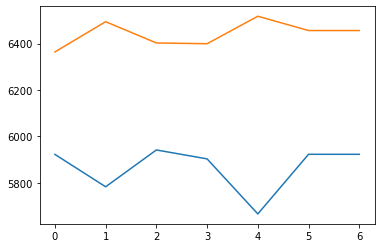

In [935]:
import matplotlib.pyplot as plt
plt.plot(training_error)
plt.plot(testing_error)

From the above graph we can see the best model is DT with sample leaf 222 and criterion as squared error

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# Random Forest Regression

In [937]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=31)

model = rfr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 2281.5301442741206
Testing Error : 6384.851618705036


## RFR with nestimators and min sample leaf

In [988]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=31,n_estimators=18 ,min_samples_leaf=37)

model = rfr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5664.060480904805
Testing Error : 6401.952724335373


In [984]:
tg = {'n_estimators':range(0,50),'min_samples_leaf':range(0,50)}
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
cv = GridSearchCV(rfr,tg,scoring ='neg_mean_absolute_error',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'min_samples_leaf': 37, 'n_estimators': 18}

## RFR with abs error

In [998]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=31,n_estimators=43 ,min_samples_split=19)

model = rfr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 4098.4739309802835
Testing Error : 6396.653656104533


In [960]:
tg = {'n_estimators':range(0,50),'min_samples_split':range(0,20)}
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=31)
cv = GridSearchCV(rfr,tg,scoring ='neg_mean_absolute_error',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'min_samples_split': 19, 'n_estimators': 43}

In [1018]:
def RFR(ne,mss):
    from sklearn.ensemble import RandomForestRegressor
    rfr = RandomForestRegressor(random_state=31,n_estimators=ne ,min_samples_split=mss)

    model = rfr.fit(xtrain,ytrain)

    pred_tr = model.predict(xtrain)
    pred_ts = model.predict(xtest)

    from sklearn.metrics import mean_absolute_error
    acc_tr = round(mean_absolute_error(ytrain,pred_tr),6)
    acc_ts = round(mean_absolute_error(ytest,pred_ts),6)
    return acc_tr,acc_ts

3 38


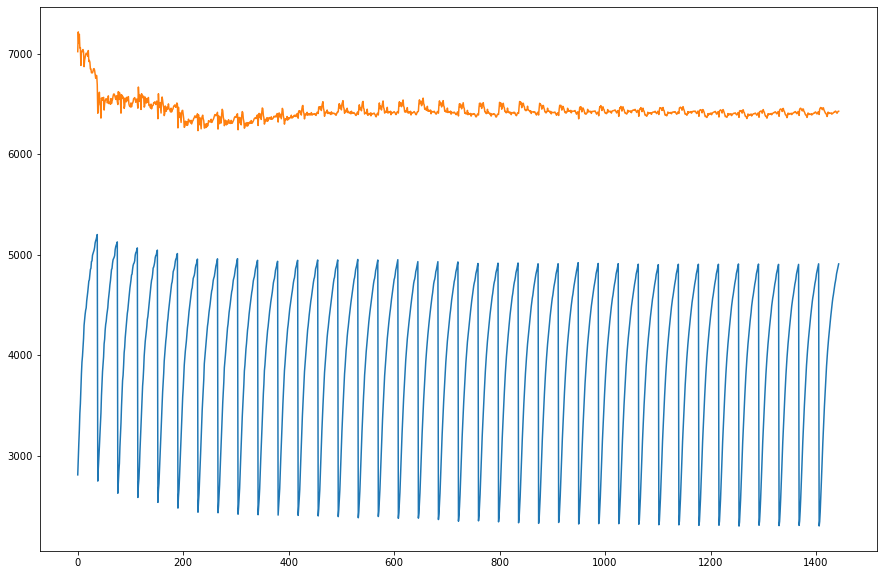

In [1019]:
accc_tr = []
accc_ts = []
for i in range(2,40):
    for j in range(2,40):
        acc_tr,acc_ts = RFR(i,j)
        if acc_ts == 6584.003694:
            print(i,j)
        accc_tr.append(acc_tr)
        accc_ts.append(acc_ts)
import matplotlib.pyplot as plt
a= range(0,(i-1)*(j-1))
plt.figure(figsize=(15,10))
plt.plot(a,accc_tr)
plt.plot(a,accc_ts)
    

# Best RFR model

In [1020]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=31,n_estimators=3 ,min_samples_split=38)

model = rfr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts )

Training Error : 5109.706051860713
Testing Error : 6584.0036936006545


In [1007]:
cd = pd.DataFrame(accc_tr,columns=['Training Error'])

In [1015]:
cd['Testing Error'] = accc_ts
cd[(cd['Training Error'] > 5100)&(cd['Testing Error'] < 6600)]

,Training Error,Testing Error
74,5109.706052,6584.003694
75,5128.088715,6527.110566


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# AdaBoost

In [994]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=2)
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(dtc,n_estimators=15,random_state=31)

model = abc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts ) 

Training Error : 6711.098286744816
Testing Error : 6976.856115107914


In [1016]:
tg = {'n_estimators':range(0,50)}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
dtc = DecisionTreeClassifier(random_state=31,max_depth=2)
abc = AdaBoostClassifier(dtc,random_state=31)
cv = GridSearchCV(abc,tg,scoring ='neg_mean_absolute_error',cv=3)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'n_estimators': 47}

In [995]:
D = pd.DataFrame(index=['Training Error','Testing Error'])

In [999]:
D['RFR-Nes and min leaf'] = [5664.060480904805,6401.952724335373]
D['RFR-Nes and min split'] = [4063.6242057583836,6426.784841893927]
D['ABR Nes'] = [6711.098286744816,6976.856115107914]
D

,RFR-Nes and min leaf,RFR-Nes and min split,ABR Nes
Training Error,5664.060481,4063.624206,6711.098287
Testing Error,6401.952724,6426.784842,6976.856115


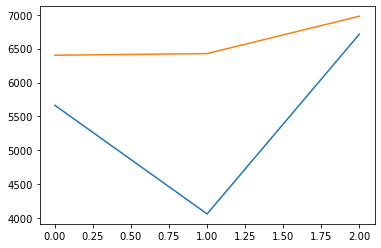

In [1000]:
training_error = D.values.tolist()[0]
testing_error = D.values.tolist()[1]
import matplotlib.pyplot as plt
plt.plot(training_error)
plt.plot(testing_error)

In [1021]:
def ABR(ne):
    from sklearn.tree import DecisionTreeClassifier
    dtc = DecisionTreeClassifier(max_depth=2)
    from sklearn.ensemble import AdaBoostClassifier
    abc = AdaBoostClassifier(dtc,n_estimators=ne,random_state=31)

    model = abc.fit(xtrain,ytrain)

    pred_tr = model.predict(xtrain)
    pred_ts = model.predict(xtest)

    from sklearn.metrics import mean_absolute_error
    acc_tr = round(mean_absolute_error(ytrain,pred_tr),6)
    acc_ts = round(mean_absolute_error(ytest,pred_ts),6)
    return acc_tr,acc_ts

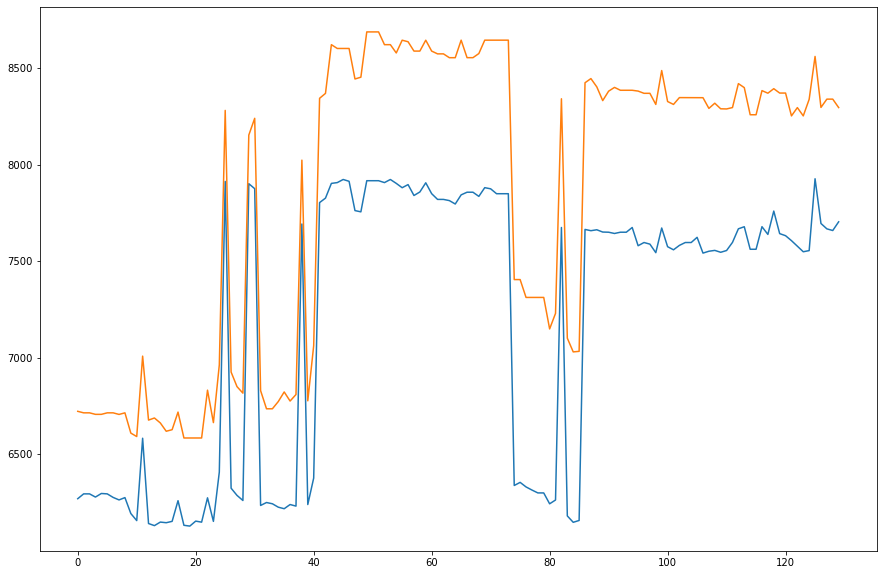

In [1029]:
accc_tr = []
accc_ts = []
for i in range(30,160):
    acc_tr,acc_ts = ABR(i)
#     if acc_ts == 6584.003694:
#         print(i,j)
    accc_tr.append(acc_tr)
    accc_ts.append(acc_ts)
import matplotlib.pyplot as plt
#a= range(0,(i-1))
plt.figure(figsize=(15,10))
plt.plot(accc_tr)
plt.plot(accc_ts)

In [1030]:
cd = pd.DataFrame(accc_tr,columns=['Training Error'])

In [1038]:
cd['Testing Error'] = accc_ts
cd[(cd['Training Error'] < 6200)&(cd['Testing Error'] < 6600)]

,Training Error,Testing Error
10,6156.458972,6591.647482
18,6132.128043,6584.190647
19,6127.990081,6584.190647
20,6153.786294,6584.190647
21,6148.396754,6584.190647


In [1042]:
for i in range(30,50):
    acc_tr,acc_ts = ABR(i)
    if acc_tr == 6127.990081:
        print(i)

49


### So from above values of best n estimators 49 create ABR model

# Best ABR model

In [1043]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=2)
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(dtc,n_estimators=49,random_state=31)

model = abc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import mean_absolute_error
acc_tr = mean_absolute_error(ytrain,pred_tr)
acc_ts = mean_absolute_error(ytest,pred_ts)
print('Training Error :',acc_tr )
print('Testing Error :',acc_ts ) 

Training Error : 6127.990081154193
Testing Error : 6584.190647482014


&nbsp;

&nbsp;

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

# Form Classification Model using Y=attrition and choose the best model

## Here we have to predict the attrition column, meaning whether the employee is retained or does he leave the company based on the different factors..
### So the Y columns is attrition which is the predicted column, and depending on the important columns (predictors X-columns) the predictions are calculated

#### Divide Dataset in X and Y

In [11]:
Y = A[['Attrition']]
X = A.drop(labels=['Attrition'],axis = 1)

First we will use Decision Tree, RandomForest and AdaBoost methods for model creation so we do not need to find important categorical and continuous columns

In [12]:
cat = []
con = []
for i in X.columns:
    if X[i].dtypes == 'object':
        cat.append(i)
    else:
        con.append(i)
        
X1 = pd.get_dummies(X[cat])
X2 = pd.DataFrame(ss.transform(X[con]),columns=con)
Xnew = X2.join(X1)

In [13]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

# Decision Tree Model

In [86]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

model = dtc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 1.0
Testing Accuracy : 0.762589928057554


### DTR models with pruning

#### Max depth best parameter

In [130]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=31,max_depth=2)

model = dtc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.8593327321911632
Testing Accuracy : 0.8345323741007195


In [131]:
tg = {'max_depth':range(0,10)}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
cv = GridSearchCV(dtr,tg,scoring ='accuracy',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'max_depth': 2}

### Checking with gini as criterion

In [152]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=31,max_depth=2,criterion='gini')

model = dtc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.8593327321911632
Testing Accuracy : 0.8345323741007195


In [151]:
tg = {'max_depth':range(0,10),'criterion':['gini','entropy']}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
cv = GridSearchCV(dtr,tg,scoring ='accuracy',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'criterion': 'gini', 'max_depth': 2}

#### Min leaf best parameter

In [132]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=31,min_samples_leaf=21)

model = dtc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.8746618575293057
Testing Accuracy : 0.8057553956834532


In [127]:
tg = {'min_samples_leaf':range(0,100)}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
cv = GridSearchCV(dtr,tg,scoring ='accuracy',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'min_samples_leaf': 23}

In [133]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=31,min_samples_leaf=23)

model = dtc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.8674481514878268
Testing Accuracy : 0.8165467625899281


### Checking with Entropy as criterion

In [150]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=31,min_samples_leaf=47,criterion='entropy')

model = dtc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.8593327321911632
Testing Accuracy : 0.8345323741007195


In [149]:
tg = {'min_samples_leaf':range(0,500),'criterion':['gini','entropy']}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
cv = GridSearchCV(dtr,tg,scoring ='accuracy',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 47}

#### Min sample split best parameters

In [134]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=31,min_samples_split=23)

model = dtc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.9098286744815148
Testing Accuracy : 0.7805755395683454


In [135]:
tg = {'min_samples_split':range(0,100)}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
cv = GridSearchCV(dtr,tg,scoring ='accuracy',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'min_samples_split': 82}

In [138]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=31,min_samples_split=82)

model = dtc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.8692515779981965
Testing Accuracy : 0.841726618705036


### Checking with Gini as criterion

In [143]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=31,min_samples_split=223,criterion='gini')

model = dtc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.8602344454463481
Testing Accuracy : 0.8309352517985612


In [145]:
tg = {'min_samples_split':range(0,1000),'criterion':['gini','entropy']}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
cv = GridSearchCV(dtr,tg,scoring ='accuracy',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'criterion': 'gini', 'min_samples_split': 223}

### Best Decision Tree model with Minimum Sample Split 82 and gini as criterion
    Training Accuracy : 0.8692515779981965
    Testing Accuracy : 0.841726618705036

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

# Random Forest Classifier

In [162]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=31)

model = rfc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 1.0
Testing Accuracy : 0.8633093525179856


### With n estimators and min leaf

In [221]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=31,n_estimators = 54 ,min_samples_leaf=19)

model = rfc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.8548241659152389
Testing Accuracy : 0.8345323741007195


In [165]:
tg = {'n_estimators':range(0,100),'min_samples_leaf':range(0,100)}
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
cv = GridSearchCV(rfc,tg,scoring ='accuracy',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'min_samples_leaf': 1, 'n_estimators': 54}

In [232]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=31,n_estimators = 39 ,min_samples_split=9,criterion='gini')

model = rfc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.9477006311992786
Testing Accuracy : 0.8489208633093526


In [401]:
def RFC(ne,mss):
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(random_state=31,n_estimators = ne ,min_samples_split=mss)

    model = rfc.fit(xtrain,ytrain)

    pred_tr = model.predict(xtrain)
    pred_ts = model.predict(xtest)

    from sklearn.metrics import accuracy_score
    acc_tr = round(accuracy_score(ytrain,pred_tr),6)
    acc_ts = round(accuracy_score(ytest,pred_ts),6)

    return acc_tr,acc_ts

4 34
5 14
5 17
5 34
7 2
7 31
8 12
8 14
8 25
9 6
10 3
10 6
10 15
11 3
11 16
11 17
12 2
12 6
12 13
12 15
12 16
13 2
13 3
13 8
13 9
13 15
13 22
14 6
14 8
14 10
15 6
15 10
15 13
15 17
16 6
16 8
17 6
17 9
17 10
17 13
18 6
18 10
18 20
19 6
19 12
19 20
20 5
20 6
20 12
20 15
20 17
21 10
21 12
21 15
21 16
21 17
21 19
21 21
22 3
22 8
22 11
22 16
22 19
23 2
23 8
23 9
23 10
23 15
23 19
24 5
24 9
24 10
24 19
25 5
25 9
25 10
25 11
25 16
25 19
26 5
26 9
26 10
26 16
26 17
27 9
27 11
27 13
27 16
27 17
27 21
28 2
28 5
28 9
28 11
28 13
28 17
29 9
29 13
29 16
30 5
30 8
31 2
31 16
31 17
32 2
32 9
32 11
32 16
32 18
33 2
33 8
33 11
33 15
33 18
34 8
34 11
34 15
35 8
35 17
35 19
36 2
36 8
36 15
36 17
37 8
37 15
37 17
38 15


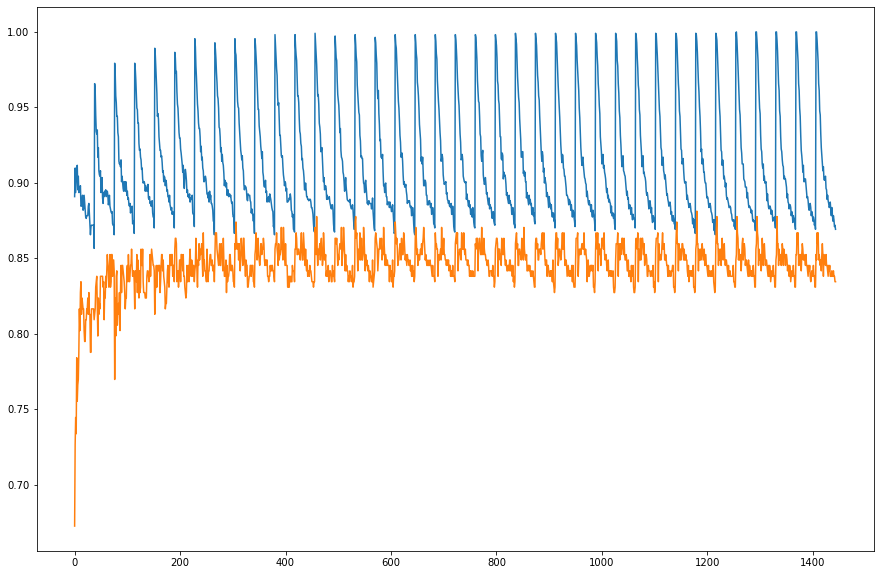

In [402]:
accc_tr = []
accc_ts = []
for i in range(2,40):
    for j in range(2,40):
        acc_tr,acc_ts = RFC(i,j)
        if acc_ts == 0.856115:
            print(i,j)
        accc_tr.append(acc_tr)
        accc_ts.append(acc_ts)
import matplotlib.pyplot as plt
a= range(0,(i-1)*(j-1))
plt.figure(figsize=(15,10))
plt.plot(a,accc_tr)
plt.plot(a,accc_ts)

In [326]:
ac = pd.DataFrame(accc_tr,columns=['acc_tr'])
ac['acc_ts'] = accc_ts
ac[(ac['acc_tr'] > 0.85) & (ac['acc_tr'] < 0.89) & (ac['acc_ts'] > 0.855)]

In [403]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=31,n_estimators = 4 ,min_samples_split=34,criterion='gini')

model = rfc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts )

Training Accuracy : 0.8827772768259693
Testing Accuracy : 0.8561151079136691


### Best RandomForest Tree model with Minimum Sample Split 34, n-estimators 34 and entropy as criterion
    Training Accuracy : 0.8827772768259693
    Testing Accuracy : 0.8561151079136691

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

# AdaBoost Model

In [606]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=31,max_depth=2,criterion='entropy')
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(dtc,n_estimators=30)

model = abc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts ) 


Training Accuracy : 0.9477006311992786
Testing Accuracy : 0.8812949640287769


In [573]:
tg = {'n_estimators':range(0,50)}
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
dtc = DecisionTreeClassifier(random_state=31,max_depth=2,criterion='entropy')
abc = AdaBoostClassifier(dtc)
cv = GridSearchCV(abc,tg,scoring ='accuracy',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'n_estimators': 7}

### Best AdaBoost model with max_depth 2 and n-estimators 30 and entropy as criterion
    Training Accuracy : 0.9477006311992786
    Testing Accuracy : 0.8812949640287769

In [600]:
def ABC(ns):
    from sklearn.tree import DecisionTreeClassifier
    dtc = DecisionTreeClassifier(random_state=31,min_samples_leaf=50,criterion='entropy')
    from sklearn.ensemble import AdaBoostClassifier
    abc = AdaBoostClassifier(dtc,n_estimators=ns)

    model = abc.fit(xtrain,ytrain)

    pred_tr = model.predict(xtrain)
    pred_ts = model.predict(xtest)

    from sklearn.metrics import accuracy_score
    acc_tr = accuracy_score(ytrain,pred_tr)
    acc_ts = accuracy_score(ytest,pred_ts)
    return acc_tr,acc_ts

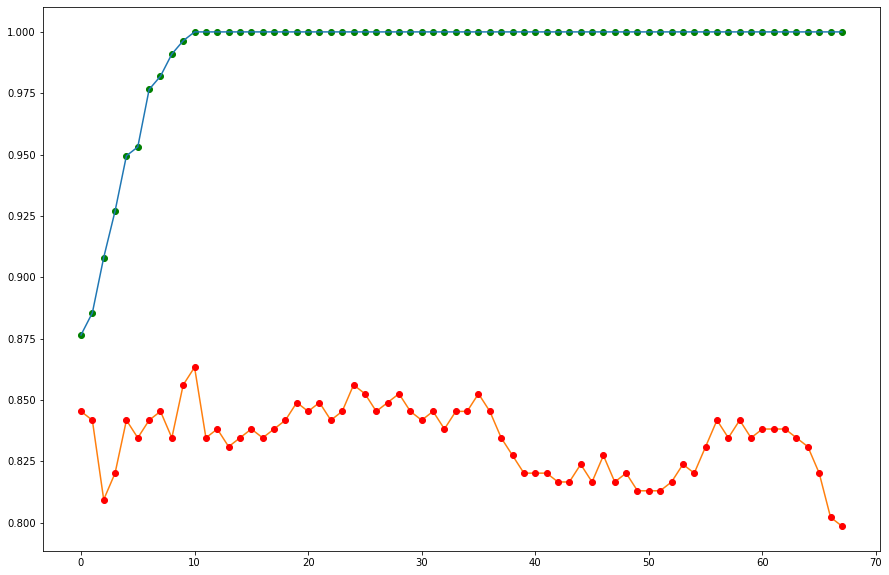

In [601]:
accc_tr = []
accc_ts = []
for i in range(2,70):
    acc_tr,acc_ts = ABC(i)
    accc_tr.append(acc_tr)
    accc_ts.append(acc_ts)
import matplotlib.pyplot as plt
a= range(0,(i-1))
plt.figure(figsize=(15,10))
plt.plot(a,accc_tr,'go')
plt.plot(a,accc_tr)
plt.plot(a,accc_ts)
plt.plot(a,accc_ts,'ro')

In [605]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=31,min_samples_leaf=43,criterion='entropy')
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(dtc,n_estimators=2)

model = abc.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts ) 

Training Accuracy : 0.8791704238052299
Testing Accuracy : 0.8525179856115108


In [602]:
def ABC(ns,sl):
    from sklearn.tree import DecisionTreeClassifier
    dtc = DecisionTreeClassifier(random_state=31,min_samples_leaf=sl,criterion='entropy')
    from sklearn.ensemble import AdaBoostClassifier
    abc = AdaBoostClassifier(dtc,n_estimators=ns)

    model = abc.fit(xtrain,ytrain)

    pred_tr = model.predict(xtrain)
    pred_ts = model.predict(xtest)

    from sklearn.metrics import accuracy_score
    acc_tr = accuracy_score(ytrain,pred_tr)
    acc_ts = accuracy_score(ytest,pred_ts)
    return acc_tr,acc_ts

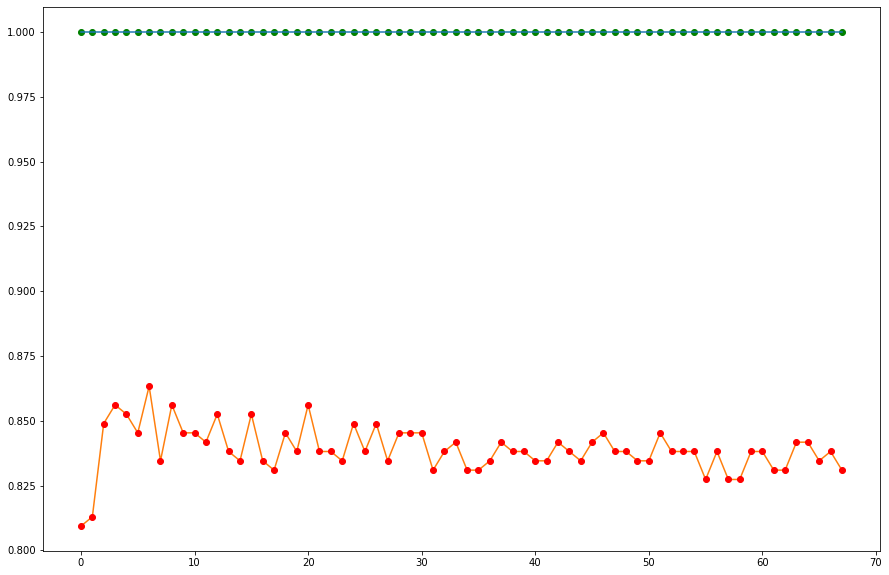

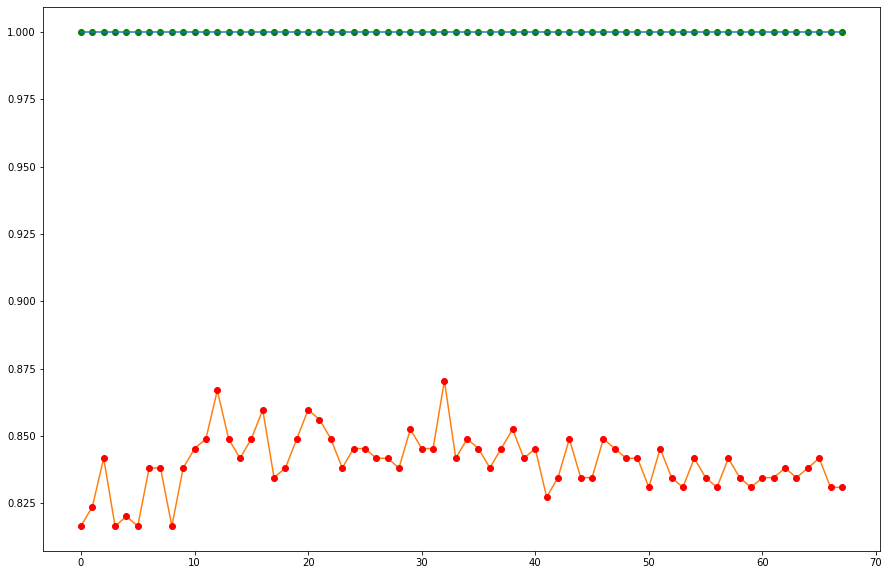

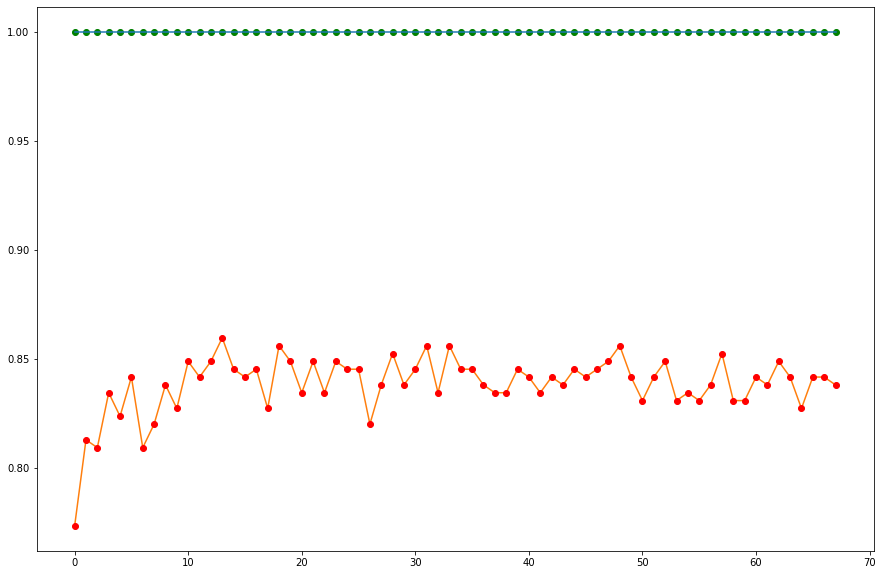

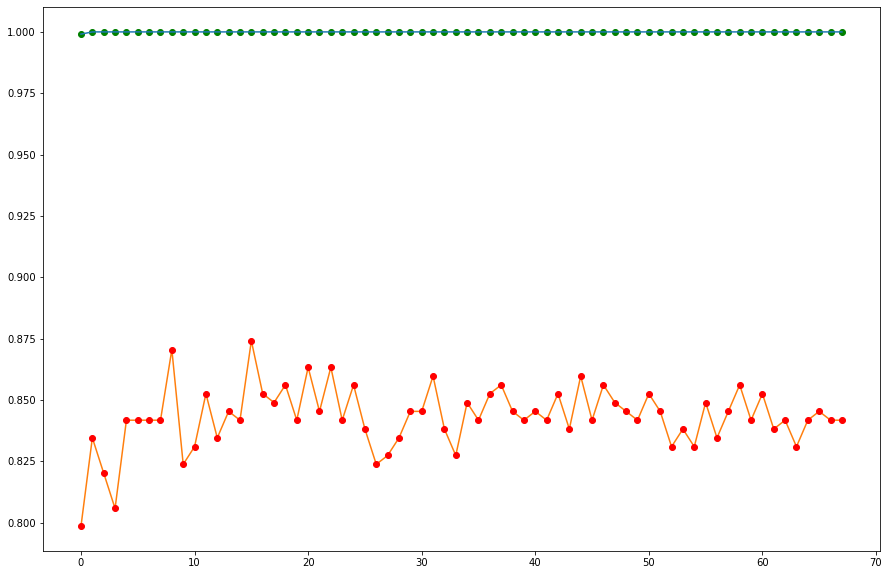

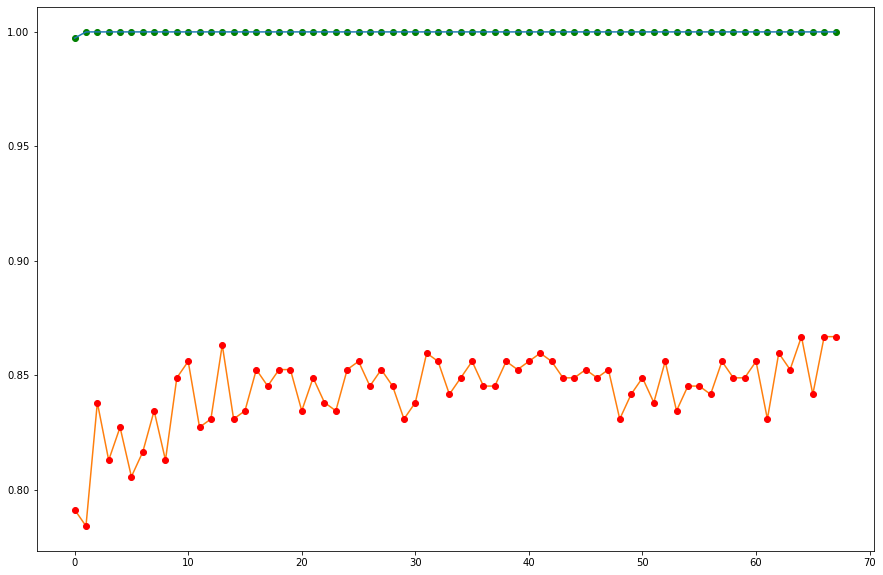

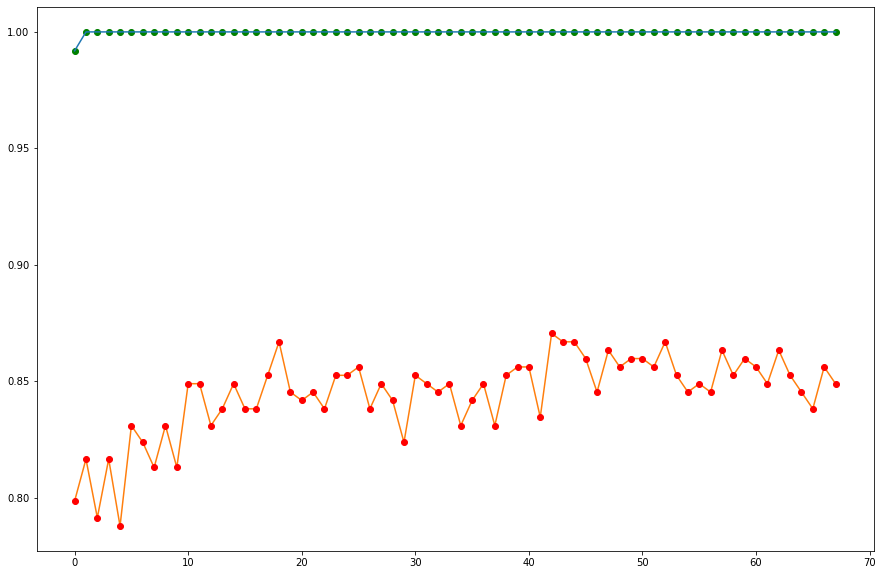

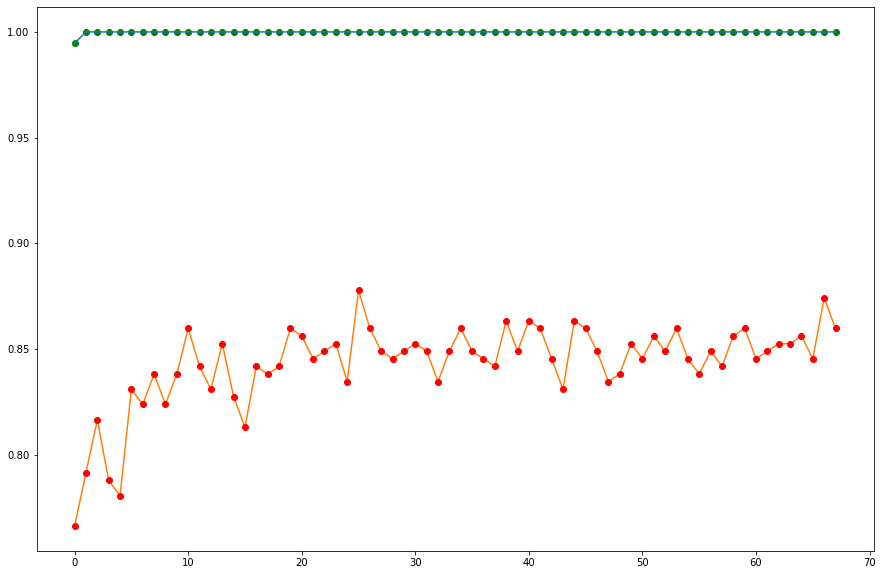

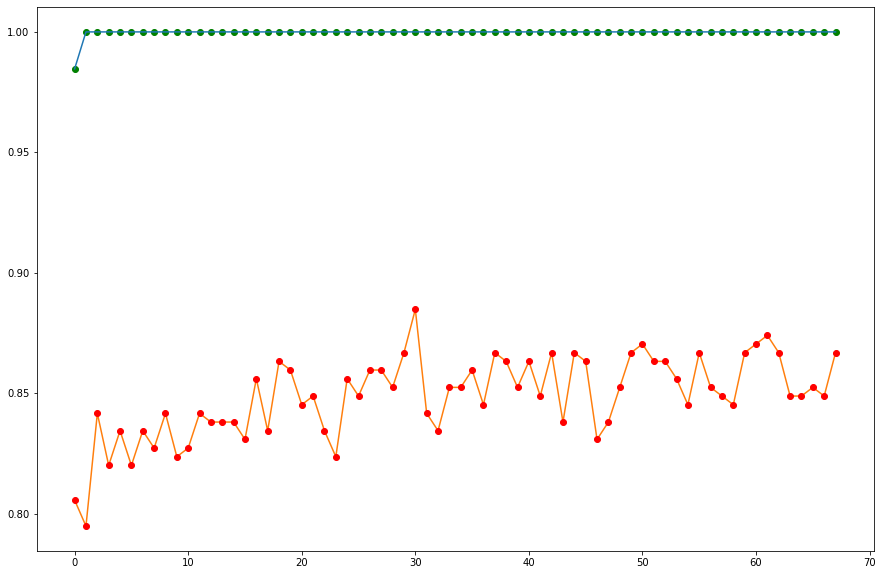

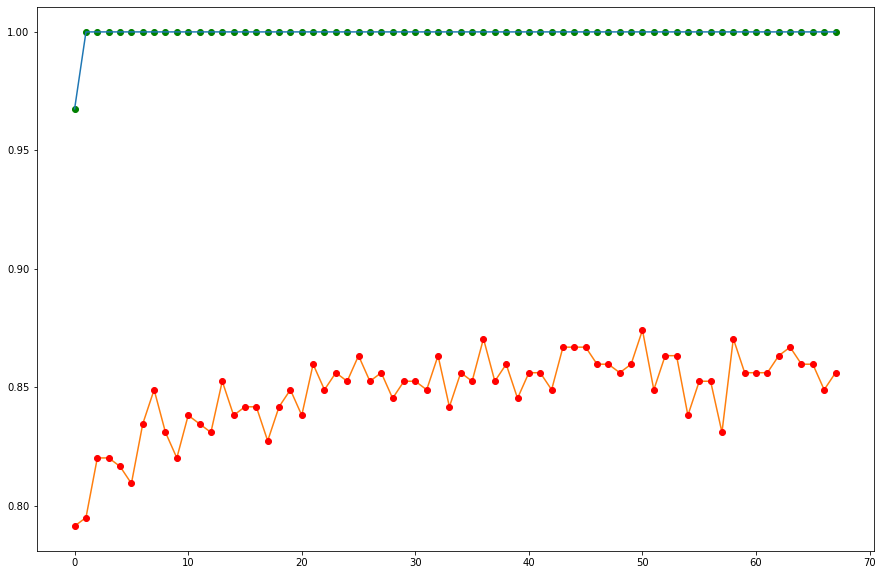

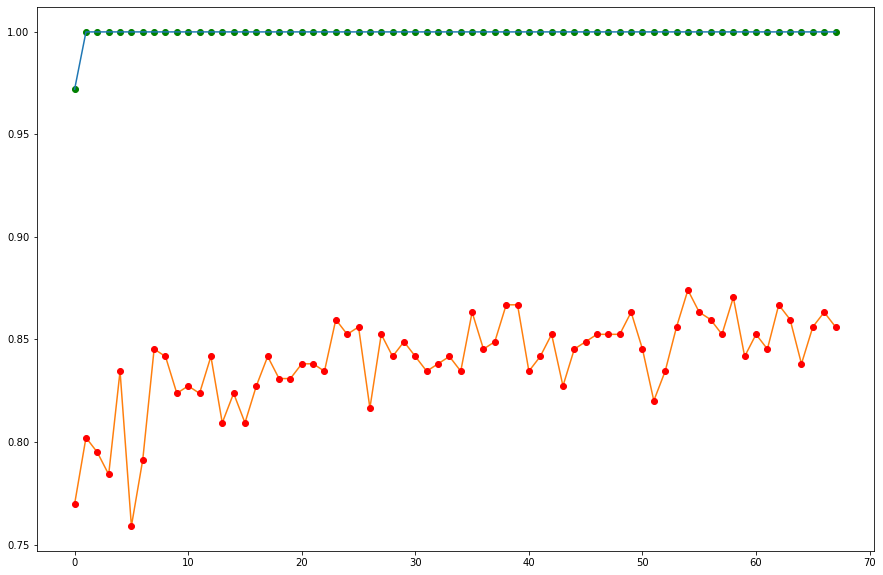

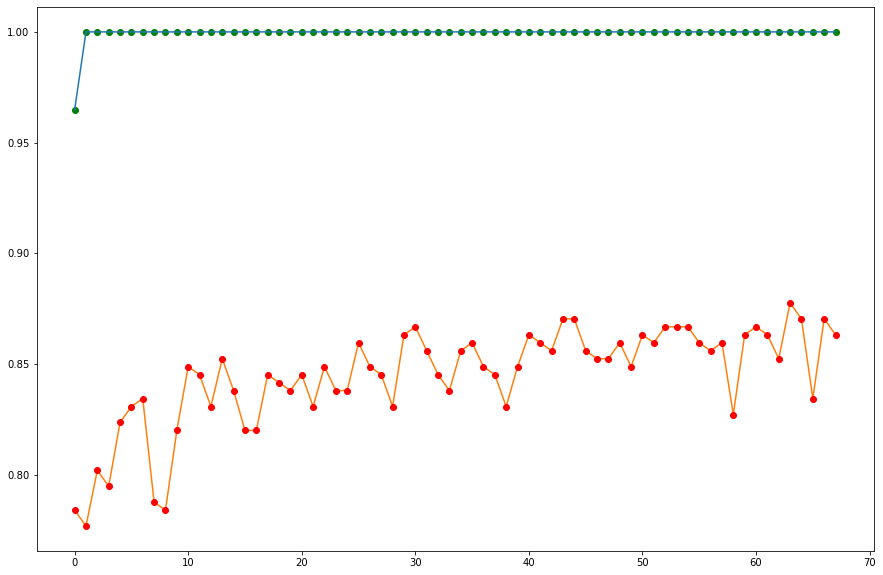

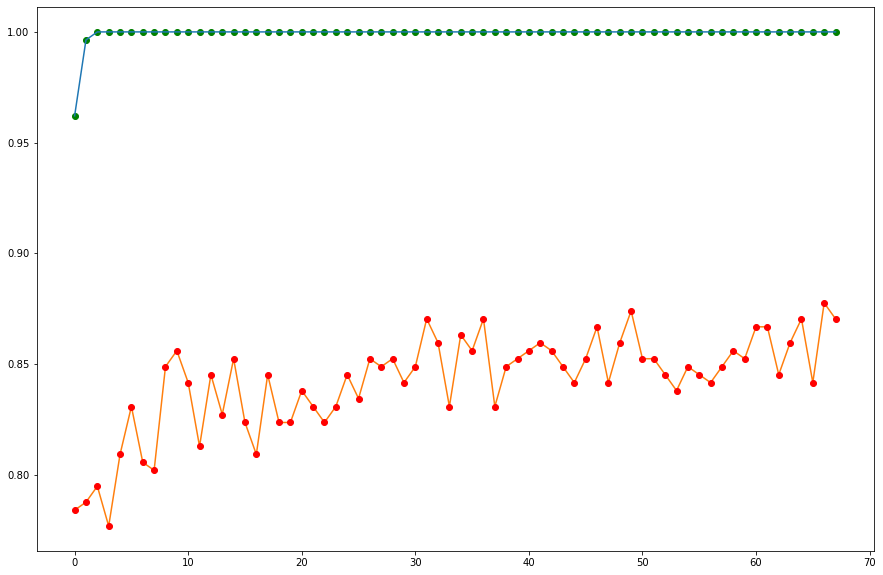

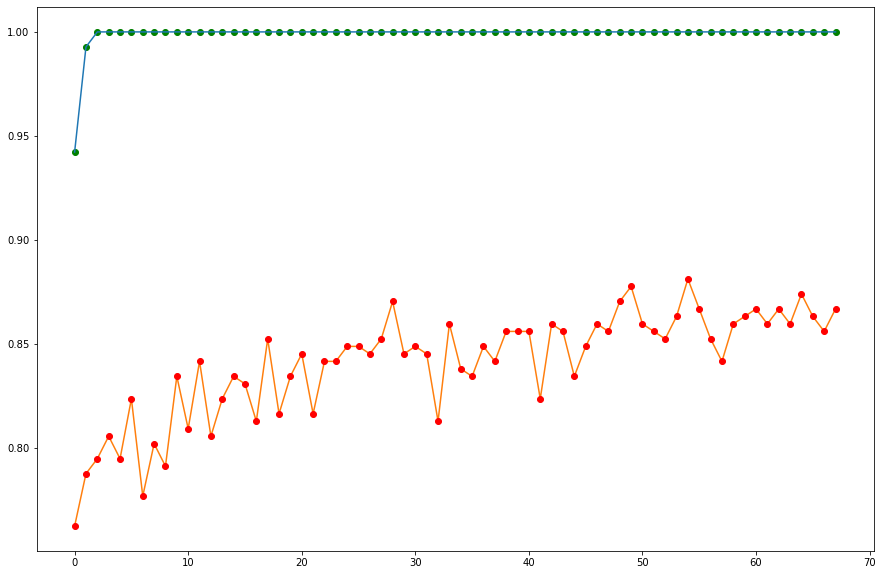

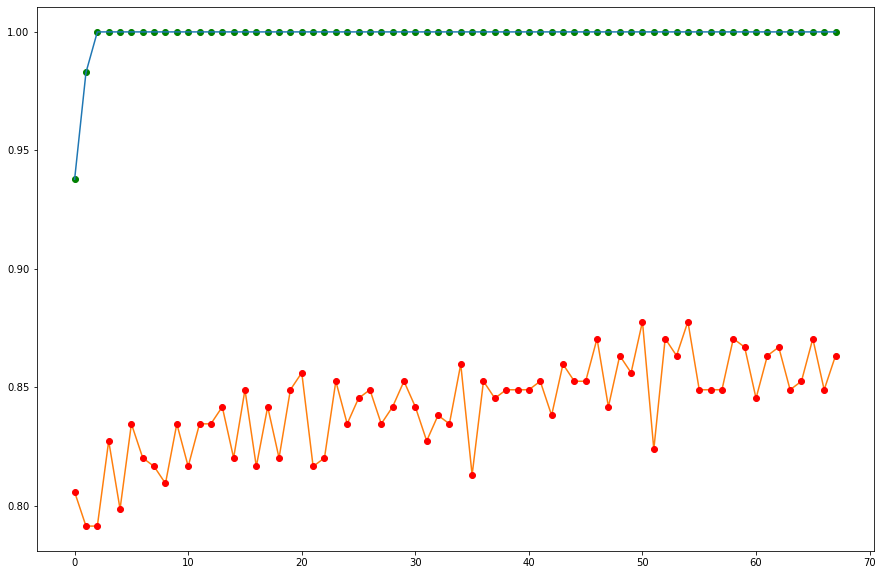

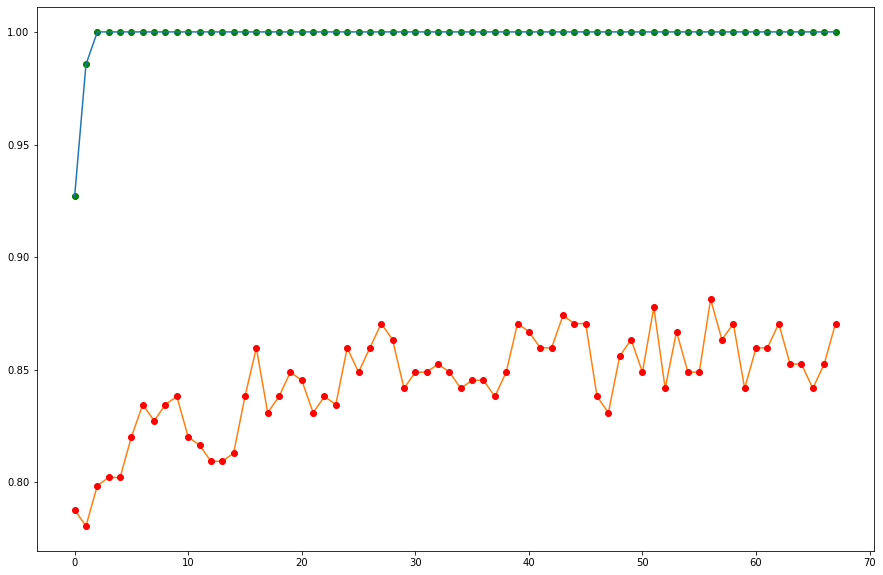

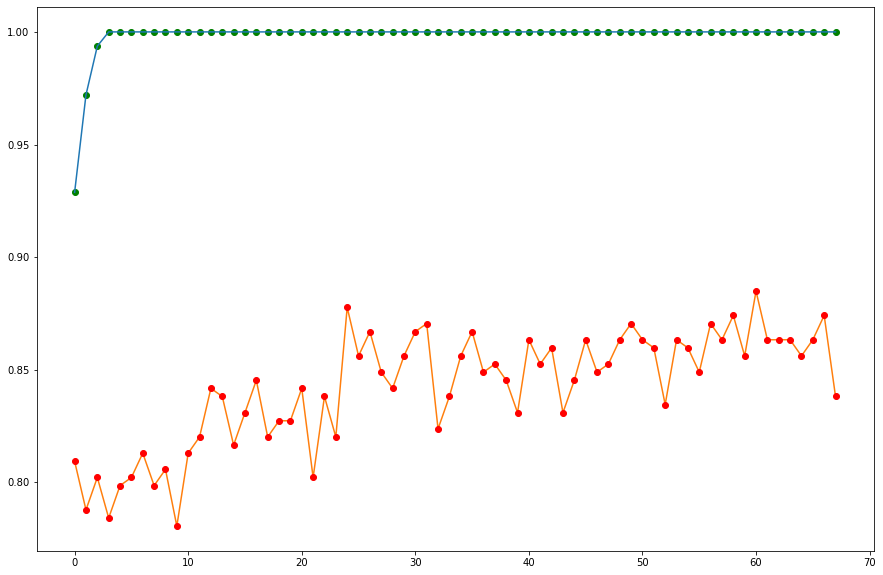

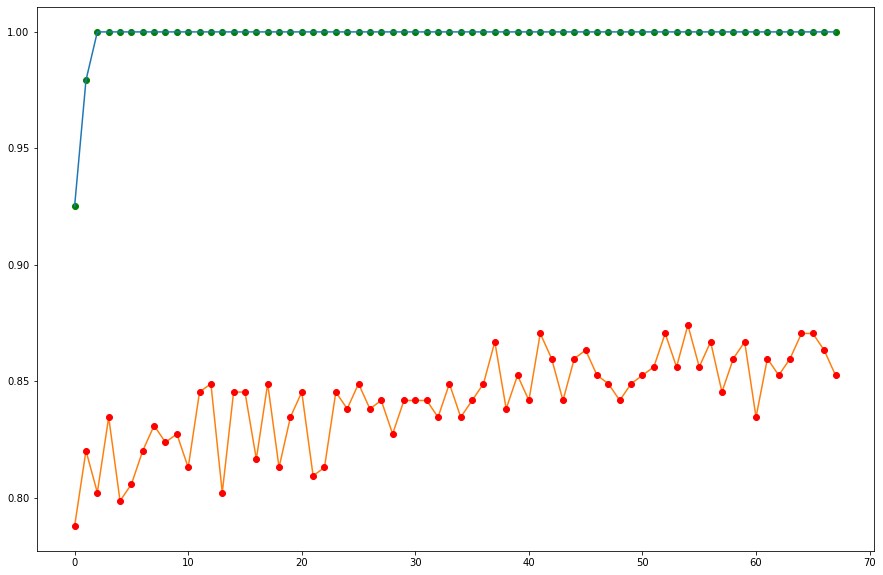

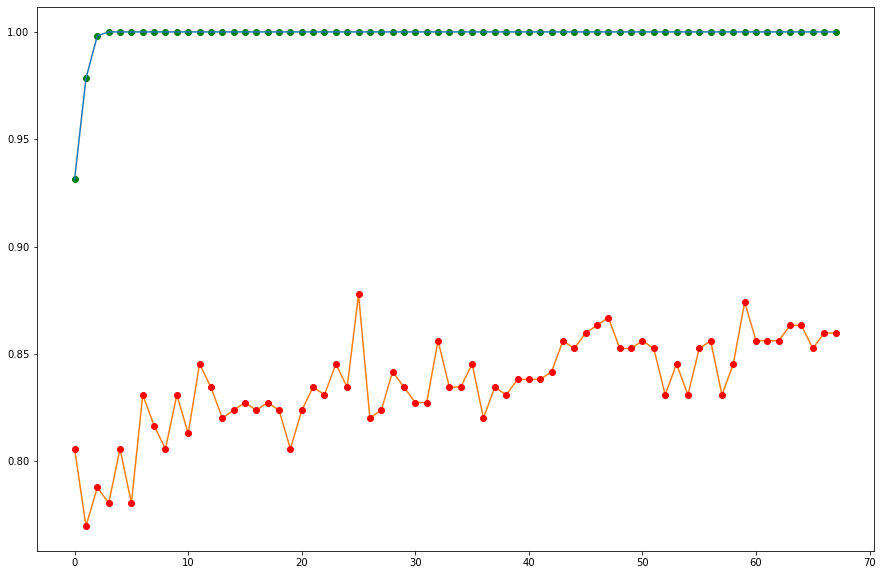

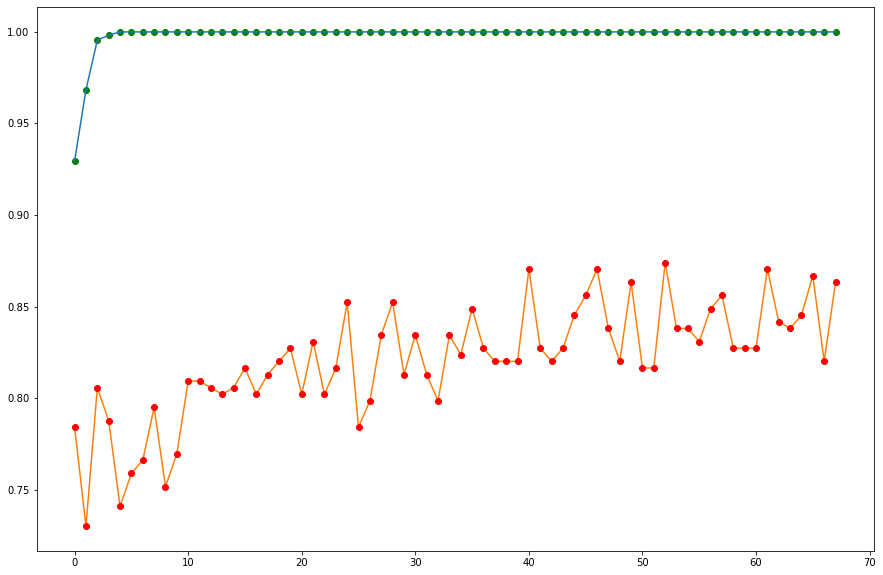

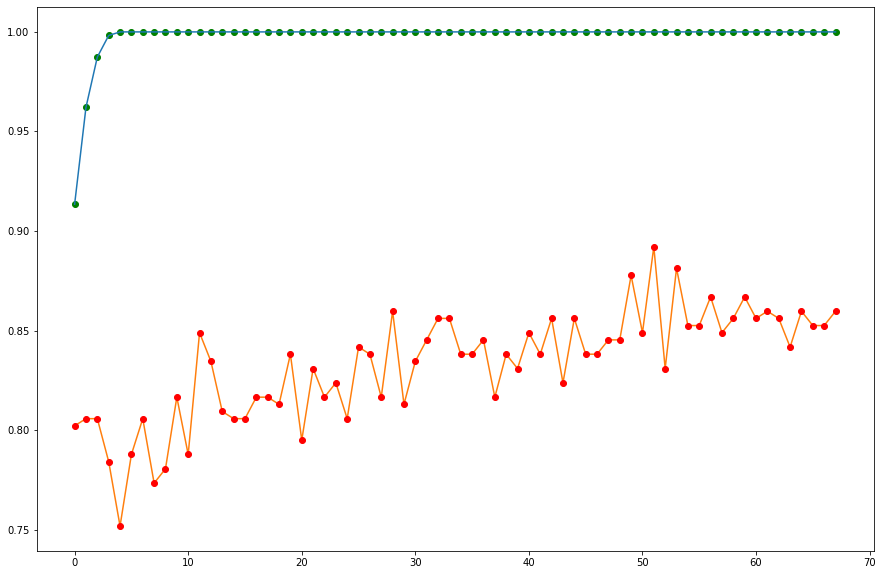

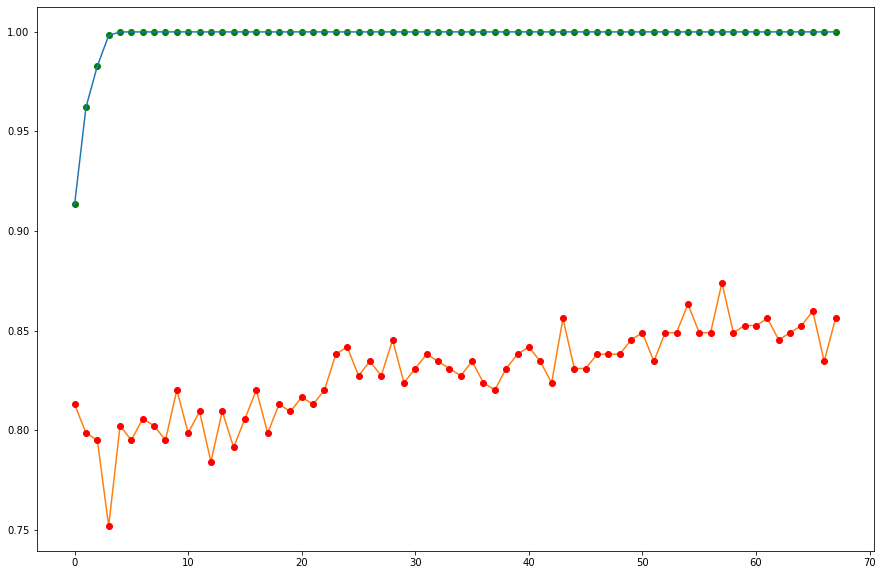

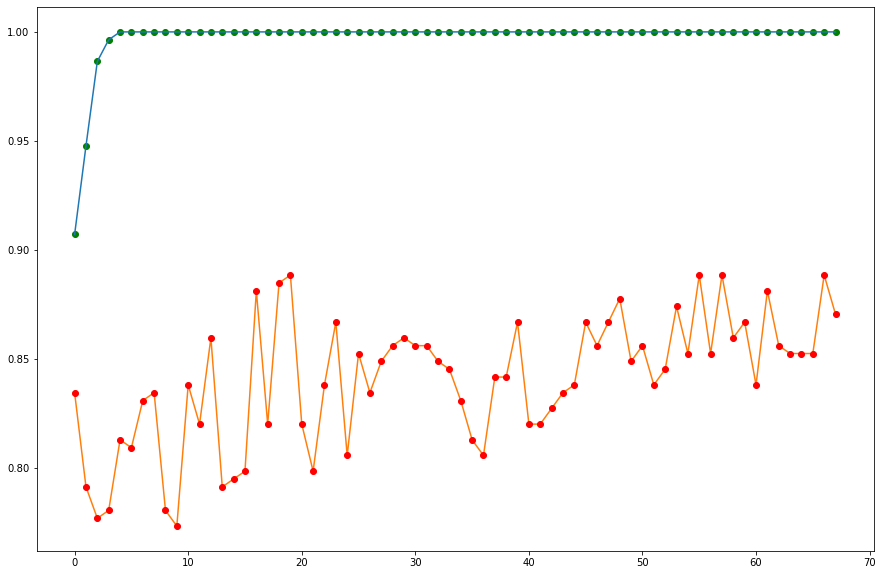

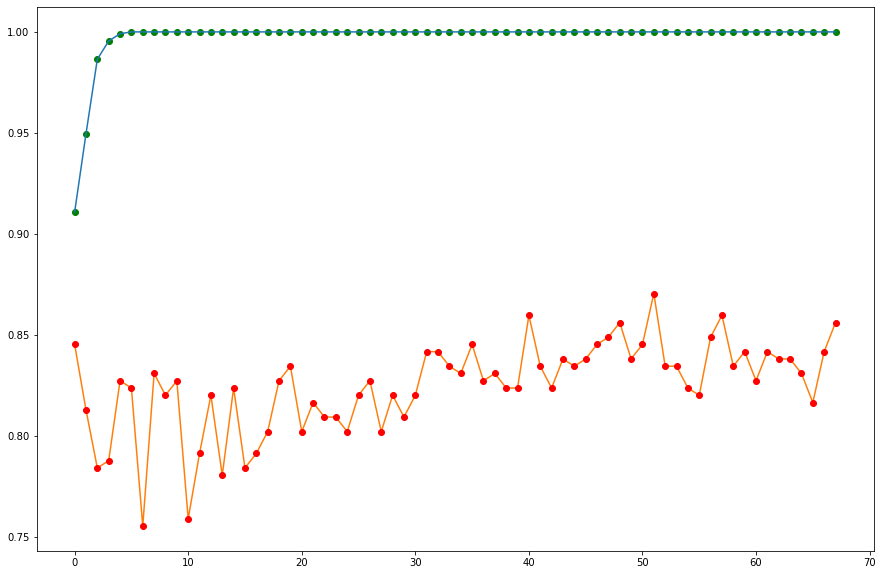

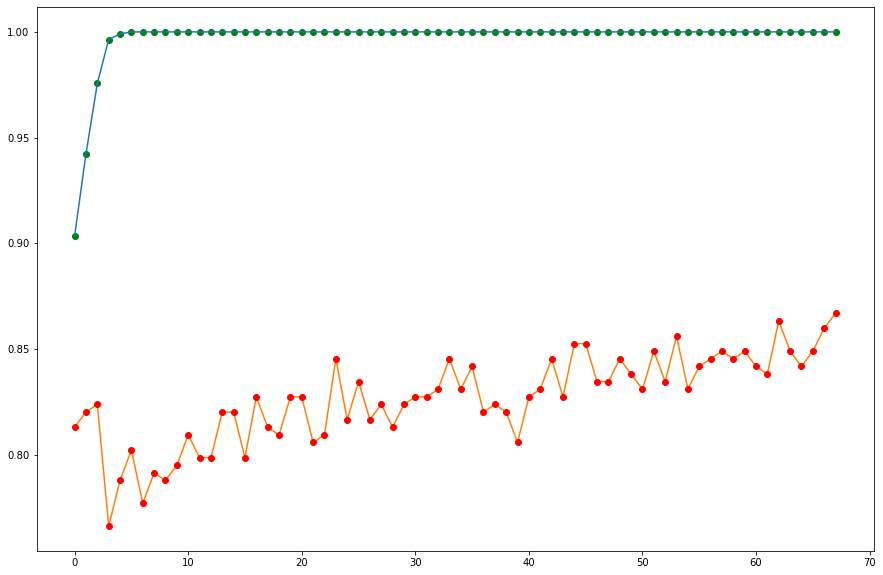

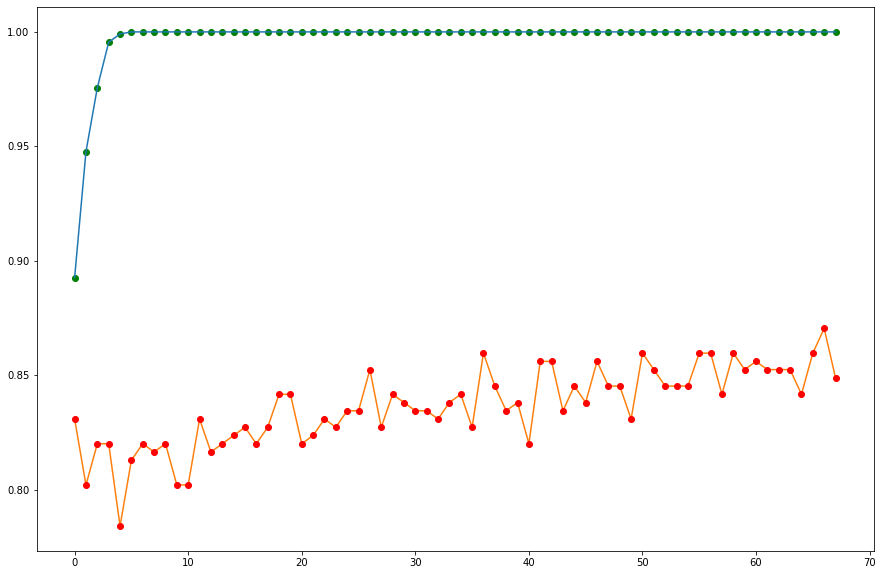

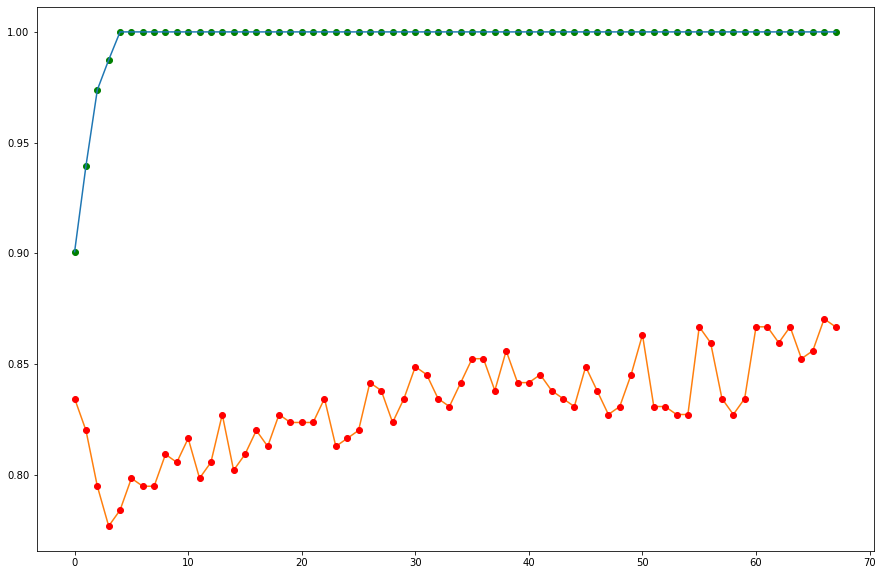

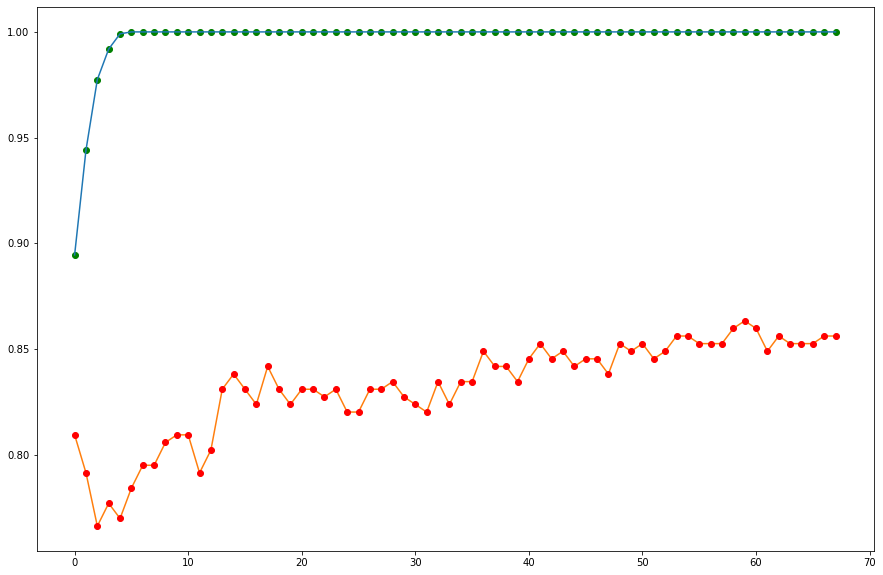

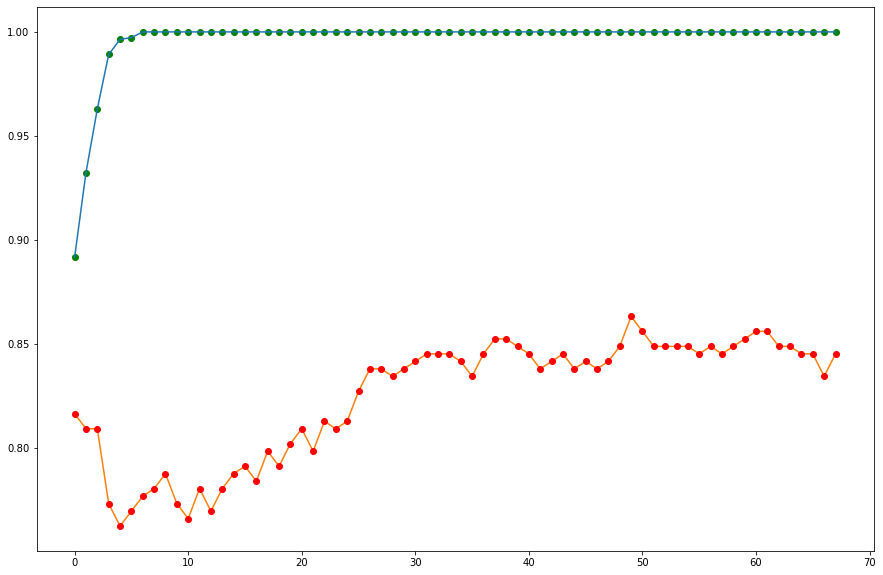

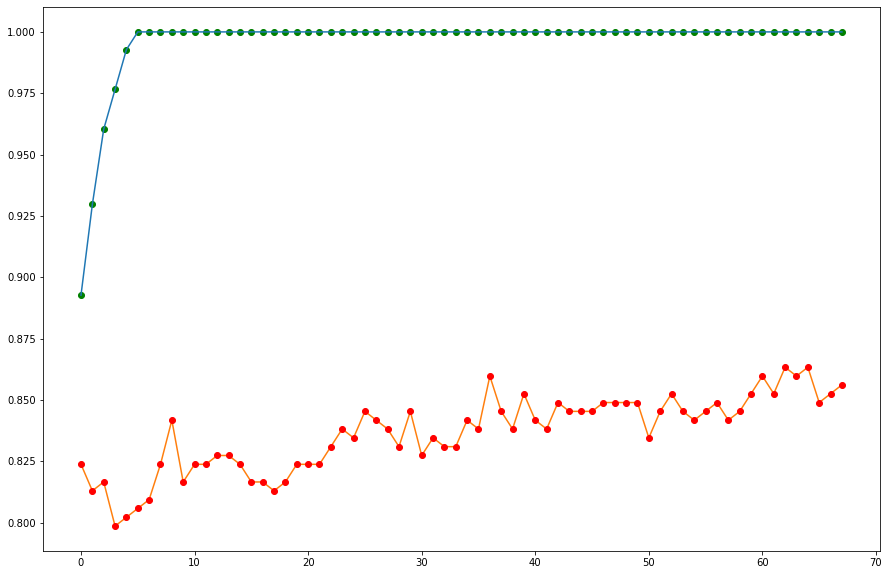

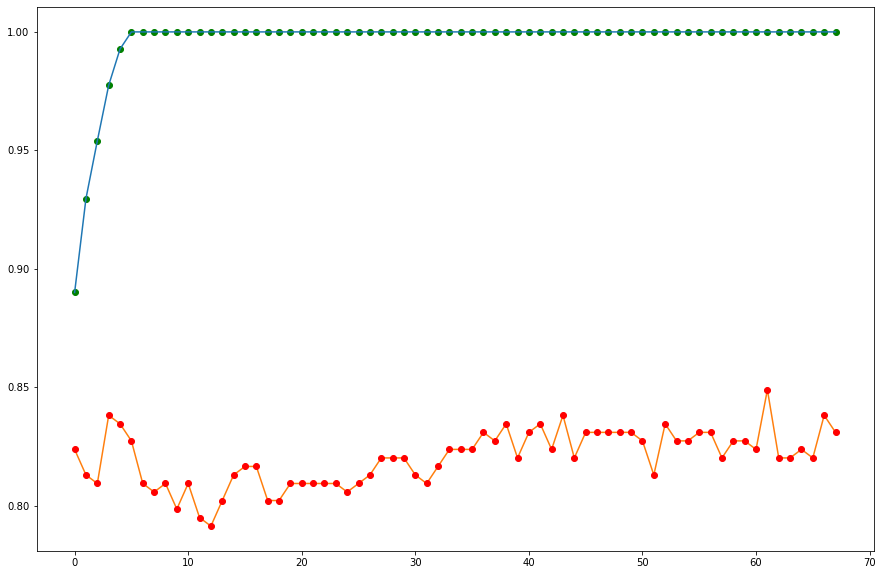

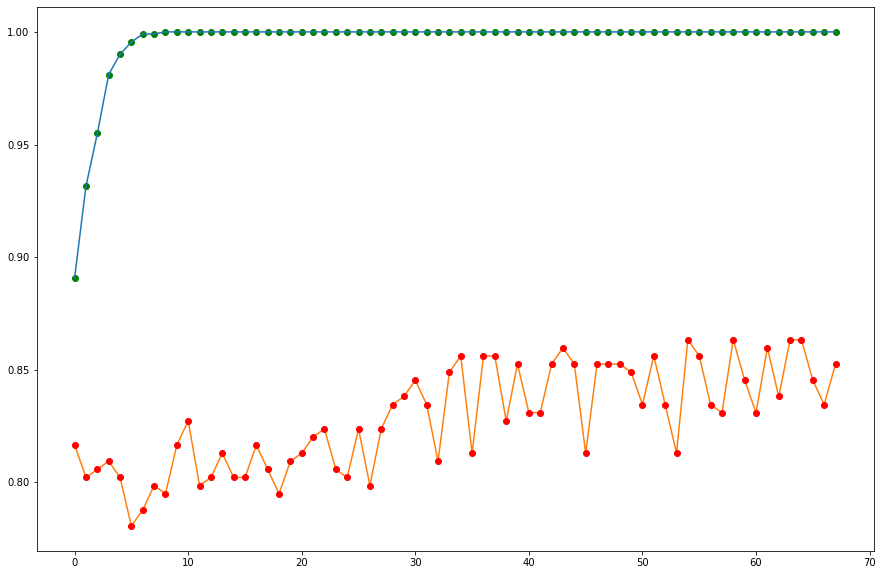

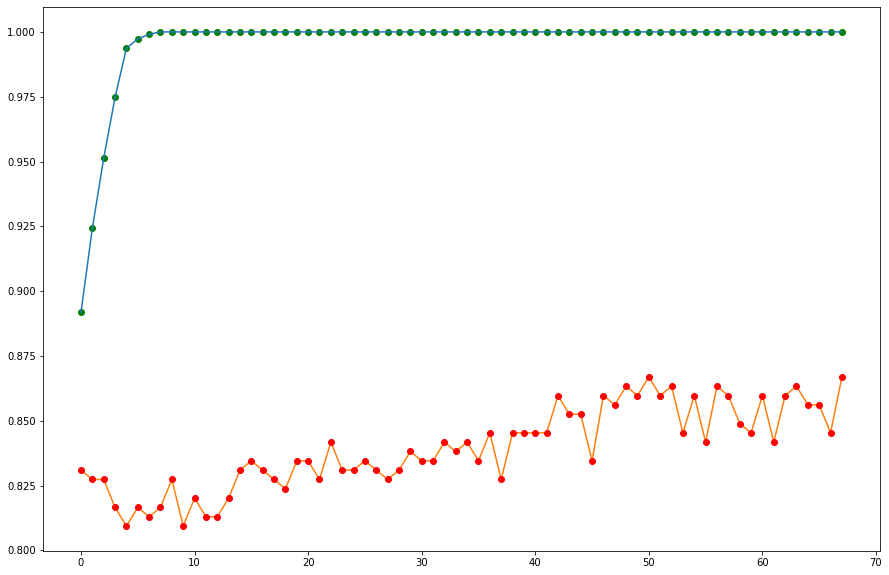

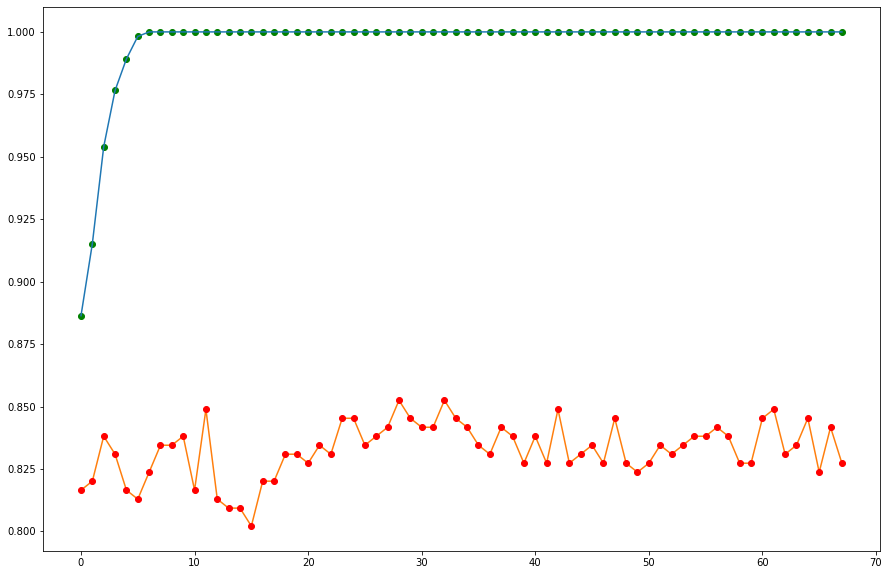

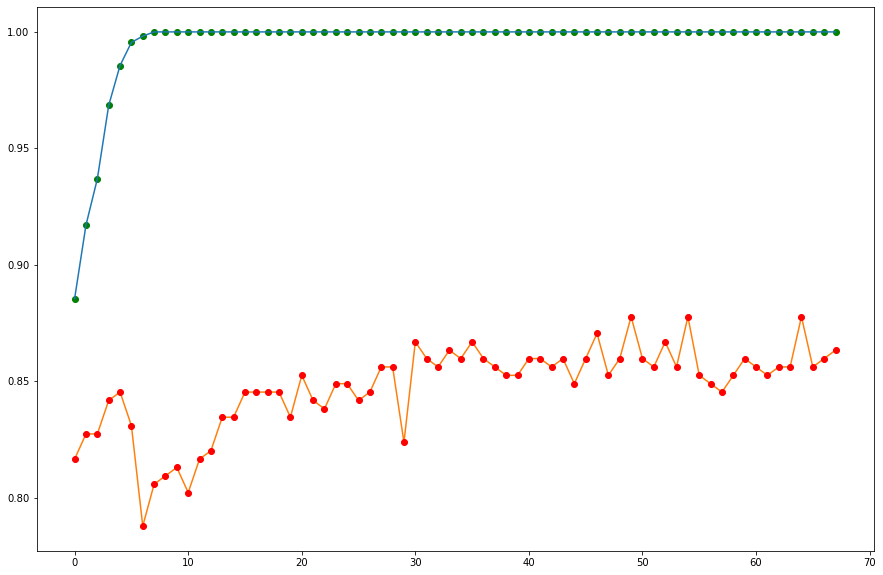

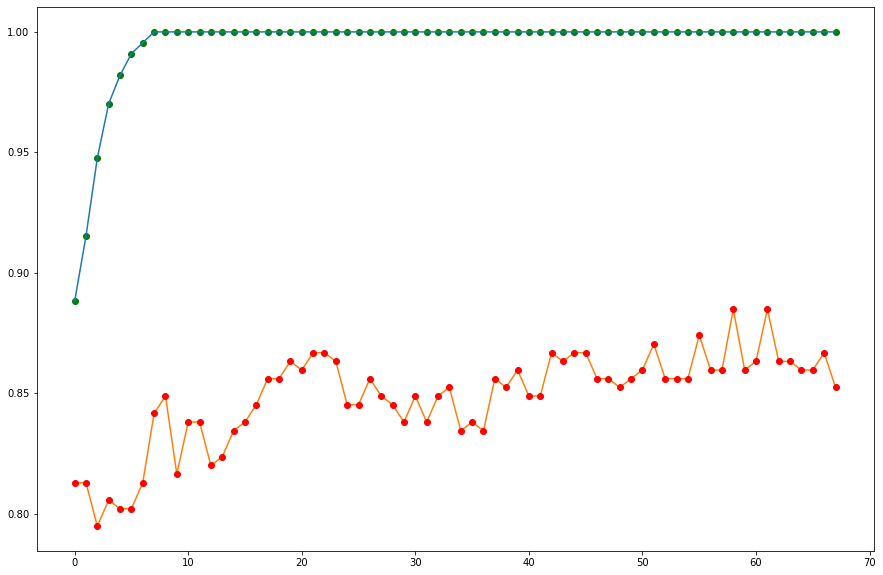

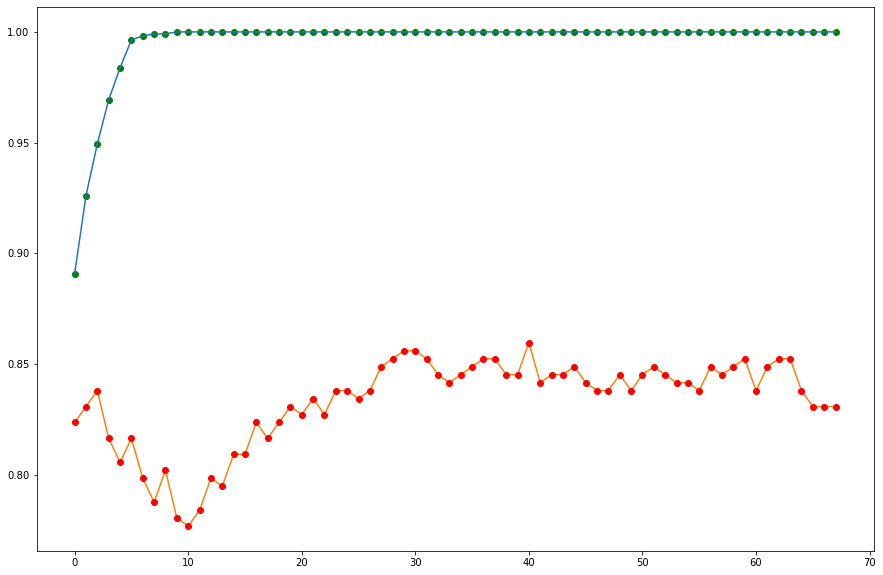

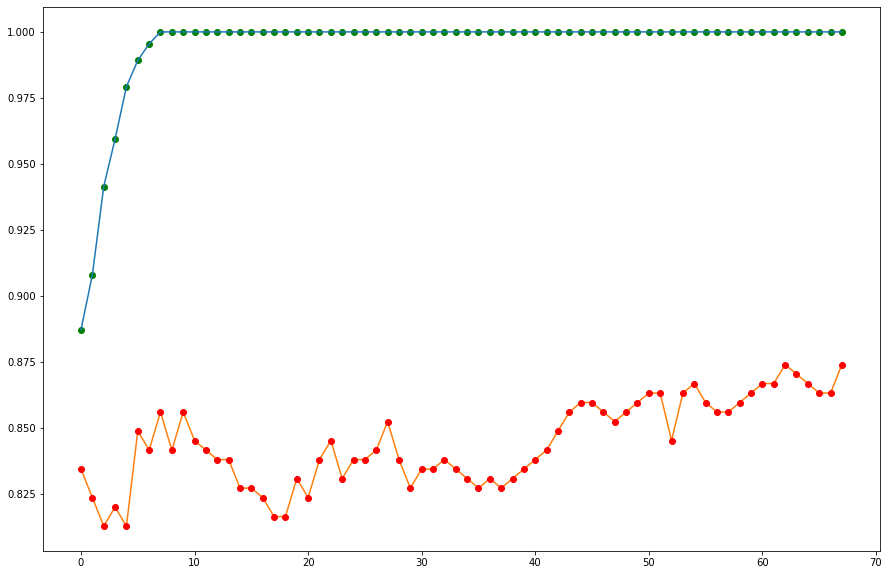

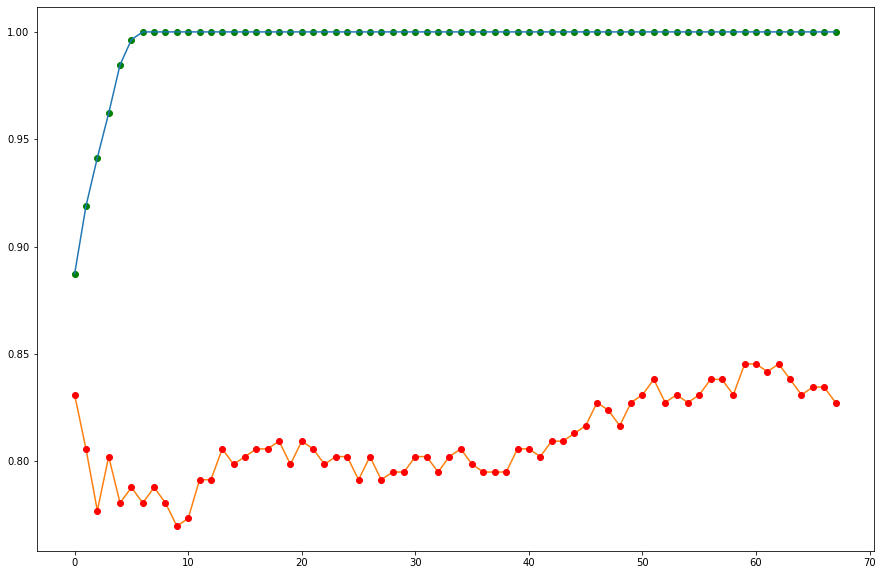

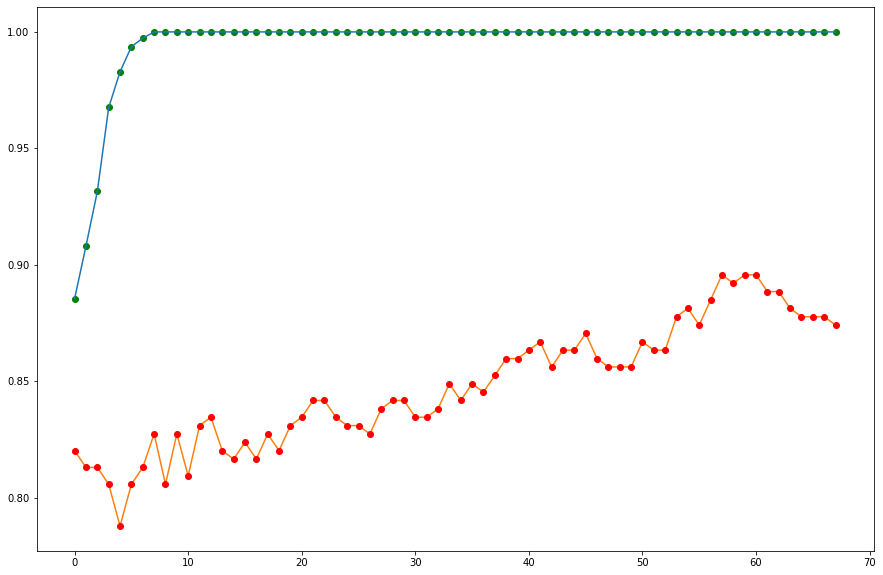

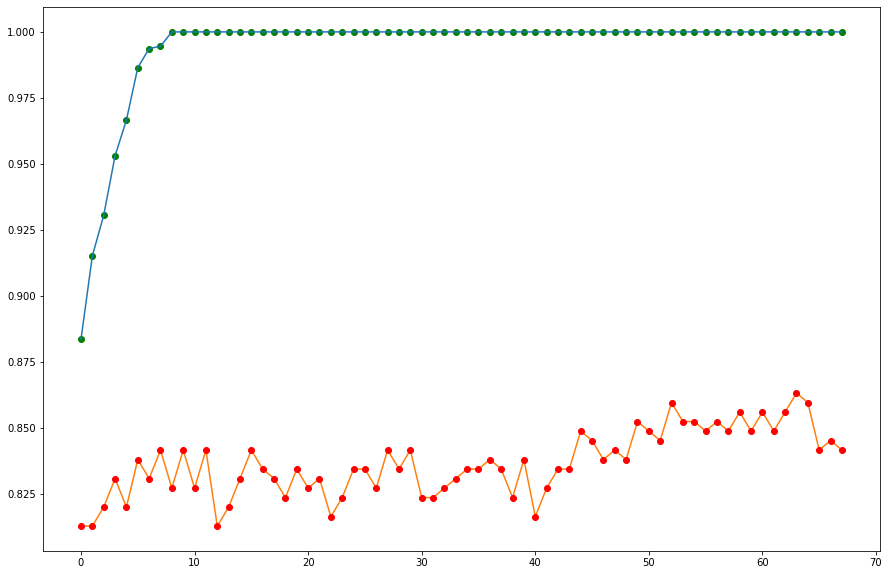

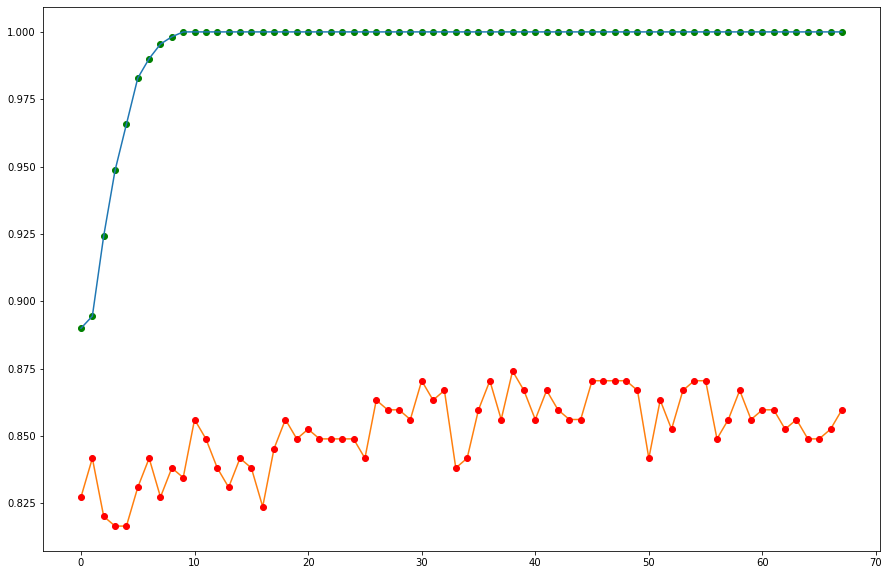

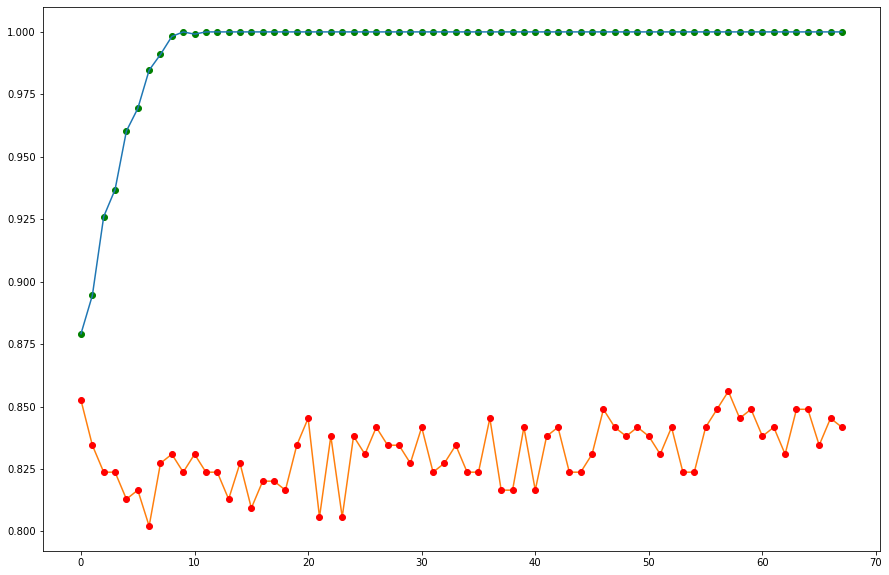

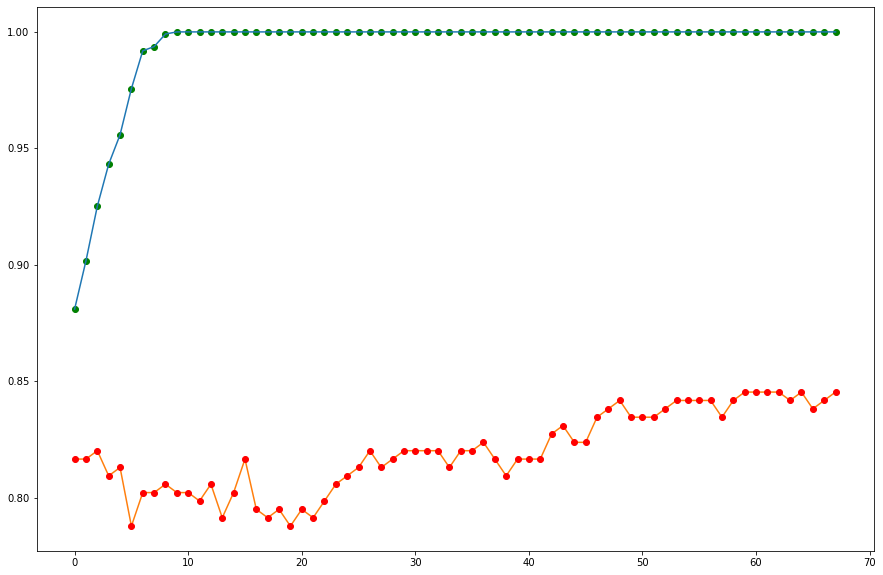

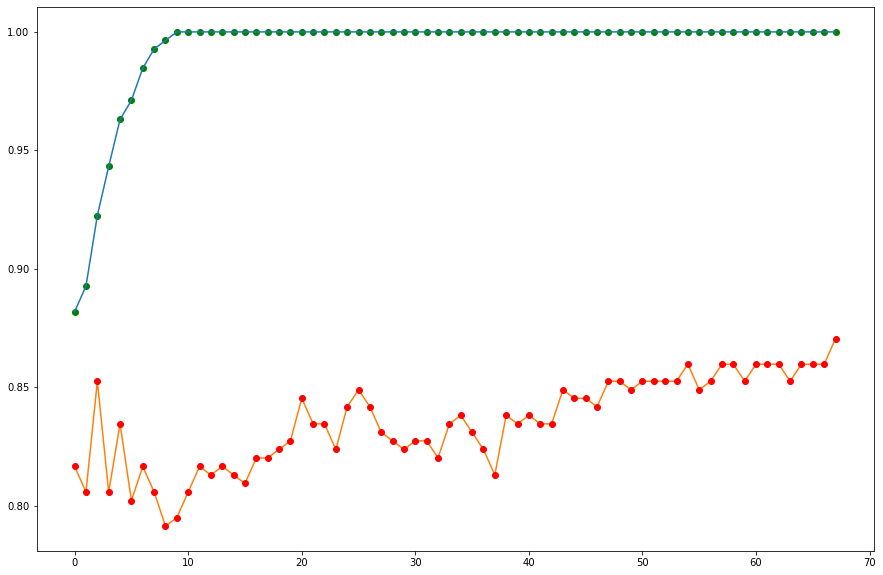

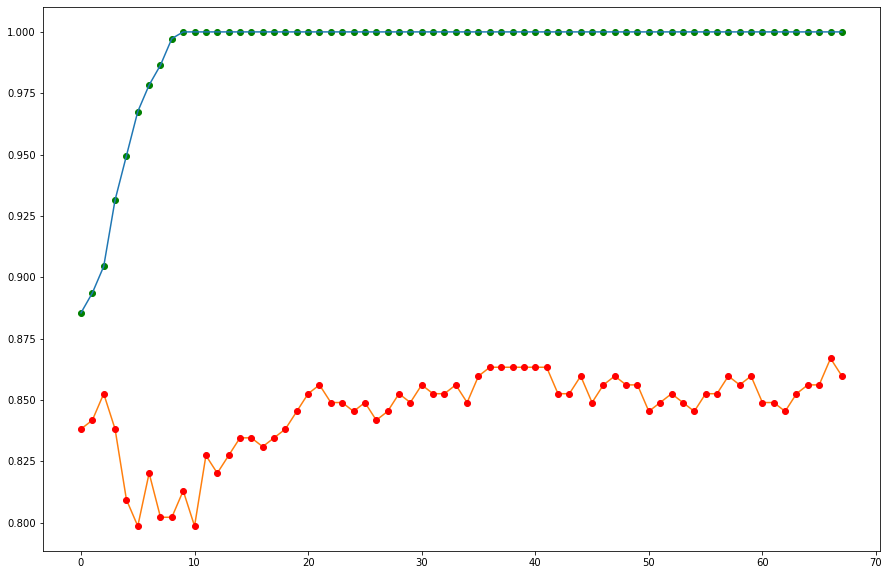

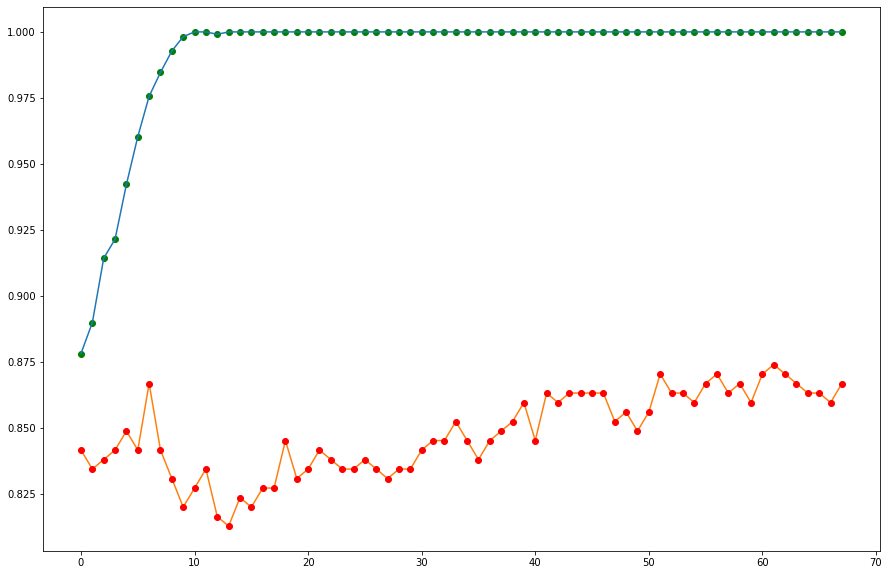

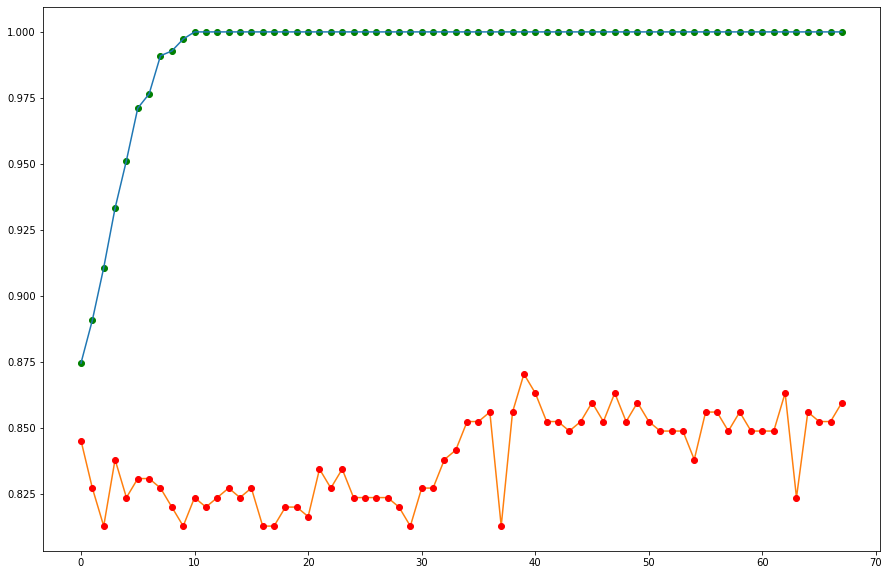

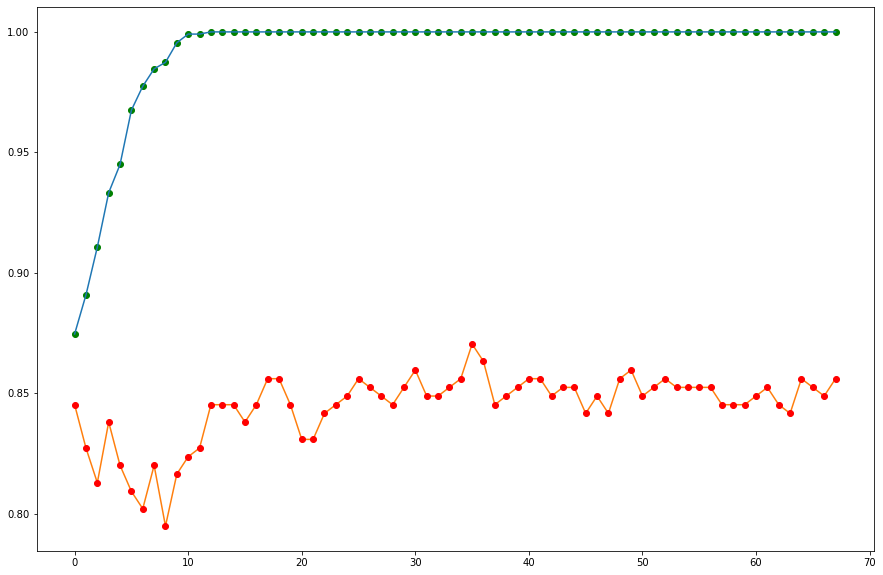

In [603]:
for j in range(2,50):
    accc_tr = []
    accc_ts = []
    for i in range(2,70):
        acc_tr,acc_ts = ABC(i,j)
        accc_tr.append(acc_tr)
        accc_ts.append(acc_ts)
    import matplotlib.pyplot as plt
    a= range(0,(i-1))
    plt.figure(figsize=(15,10))
    plt.plot(a,accc_tr,'go')
    plt.plot(a,accc_tr)
    plt.plot(a,accc_ts)
    plt.plot(a,accc_ts,'ro')

### 2nd Best AdaBoost model with max_depth 2 and n-estimators 30 and entropy as criterion
    Training Accuracy : 0.8791704238052299
    Testing Accuracy : 0.8525179856115108

# Logistic Regression

In [607]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2')

model = lr.fit(xtrain,ytrain)

pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts ) 

Training Accuracy : 0.8899909828674482
Testing Accuracy : 0.8633093525179856


### Best model with
    Training Accuracy : 0.8899909828674482
    Testing Accuracy : 0.8633093525179856

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

&emsp;

# KNN

### finding important columns by ANOVA and chisq for attrition

In [1069]:
def chi(df,cat1,cat2):
    from scipy.stats.contingency import chi2_contingency
    x = pd.crosstab(df[cat1],df[cat2])
    a,b,c,d = chi2_contingency(x)
    return b

In [1081]:
con = []
cat = []
for i in A.columns:
    if A[i].dtypes == 'object':
        cat.append(i)
    else:
        con.append(i)
        
for i in cat:
    print('--------')
    x = chi(A,'Attrition',i)
    print('Attrition vs ',i)
    print(x)

--------
Attrition vs  BusinessTravel
9.02524682067518e-06
--------
Attrition vs  Department
0.003518846170755687
--------
Attrition vs  EducationField
0.01269898080085869
--------
Attrition vs  Gender
0.20187482138327473
--------
Attrition vs  JobRole
1.795717418076309e-14
--------
Attrition vs  MaritalStatus
1.6475403386472168e-10
--------
Attrition vs  OverTime
2.098891883915361e-21
--------
Attrition vs  Attrition
5.269162061149602e-302


In [1079]:
imp_cat_col = ['BusinessTravel','Department','EducationField','JobRole','MaritalStatus','OverTime']

In [1085]:
imp_con_col = []
for i in con:
    print('--------')
    x = ANOVA(A,'Attrition',i)
    print('Attrition vs ',i)
    print(x)
    if x < .05:
        imp_con_col.append(i)

--------
Attrition vs  Age
0.0
--------
Attrition vs  DailyRate
0.0331
--------
Attrition vs  DistanceFromHome
0.0023
--------
Attrition vs  Education
0.2235
--------
Attrition vs  EnvironmentSatisfaction
0.0
--------
Attrition vs  HourlyRate
0.9545
--------
Attrition vs  JobInvolvement
0.0
--------
Attrition vs  JobLevel
0.0
--------
Attrition vs  JobSatisfaction
0.0
--------
Attrition vs  MonthlyIncome
0.0
--------
Attrition vs  MonthlyRate
0.5796
--------
Attrition vs  NumCompaniesWorked
0.061
--------
Attrition vs  PercentSalaryHike
0.8156
--------
Attrition vs  PerformanceRating
0.6883
--------
Attrition vs  RelationshipSatisfaction
0.0513
--------
Attrition vs  StockOptionLevel
0.0
--------
Attrition vs  TotalWorkingYears
0.0
--------
Attrition vs  TrainingTimesLastYear
0.0329
--------
Attrition vs  WorkLifeBalance
0.0199
--------
Attrition vs  YearsAtCompany
0.0
--------
Attrition vs  YearsInCurrentRole
0.0
--------
Attrition vs  YearsSinceLastPromotion
0.2761
--------
Attrition

In [1086]:
imp_col = imp_con_col + imp_cat_col

In [1089]:
Y = A[['Attrition']]
X = A.drop(labels=['Attrition'],axis = 1)
X = X[imp_col]

In [1090]:
cat = []
con = []
for i in X.columns:
    if X[i].dtypes == 'object':
        cat.append(i)
    else:
        con.append(i)
        
X1 = pd.get_dummies(X[cat])
X2 = pd.DataFrame(ss.fit_transform(X[con]),columns=con)

Xnew = X2.join(X1)

In [1093]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)

from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

model = knc.fit(xtrain,ytrain)
pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts ) 

Training Accuracy : 0.8818755635707844
Testing Accuracy : 0.8561151079136691


In [1094]:
tg = {'n_neighbors':range(0,30)}
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()
cv = GridSearchCV(knc,tg,scoring ='accuracy',cv=4)
cvmodel = cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'n_neighbors': 12}

## Best KNN Model 

In [1095]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)

from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=12)

model = knc.fit(xtrain,ytrain)
pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts ) 

Training Accuracy : 0.8602344454463481
Testing Accuracy : 0.8525179856115108


&emsp;

### KNN without factoring important columns

In [1096]:
Y = A[['Attrition']]
X = A.drop(labels=['Attrition'],axis=1)

In [1097]:
cat = []
con = []
for i in X.columns:
    if X[i].dtypes == 'object':
        cat.append(i)
    else:
        con.append(i)
        
X1 = pd.get_dummies(X[cat])
X2 = pd.DataFrame(ss.fit_transform(X[con]),columns=con)

Xnew = X2.join(X1)

In [1098]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)

from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

model = knc.fit(xtrain,ytrain)
pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

from sklearn.metrics import accuracy_score
acc_tr = accuracy_score(ytrain,pred_tr)
acc_ts = accuracy_score(ytest,pred_ts)
print('Training Accuracy :',acc_tr )
print('Testing Accuracy :',acc_ts ) 

Training Accuracy : 0.8638412984670875
Testing Accuracy : 0.8345323741007195


&emsp;

&emsp;

&emsp;

# ANN

In [3]:
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
from os import chdir
chdir('/Users/sourabhdabke/Documents/ETL_Hive/Python/Week_22/Proj5')

In [4]:
C = pd.read_csv('HR-Employee-Attrition.csv')

In [5]:
Y = C[['Attrition']]
X = C.drop(labels=['Attrition'],axis=1)

In [7]:
cat = []
con = []
for i in X.columns:
    if X[i].dtypes == 'object':
        cat.append(i)
    else:
        con.append(i)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X1 = pd.get_dummies(X[cat])
X2 = pd.DataFrame(ss.fit_transform(X[con]),columns=con)

Xnew = X2.join(X1)

In [8]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(Xnew,Y,test_size=.2,random_state=31)

### NN

In [11]:
xtrain.shape

(1176, 55)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

#es = EarlyStopping(patience=70,monitor= 'val_accuracy')
sgd = SGD(learning_rate=0.2,momentum=0.2)
nn = Sequential()
nn.add(Dense(50,input_dim = xtrain.shape[1]))
nn.add(Dense(400))
nn.add(Dropout(0.35))
nn.add(Dense(400))
nn.add(Dropout(0.35))
nn.add(Dense(1,activation='relu'))
nn.compile(metrics='accuracy',loss='binary_crossentropy',optimizer=sgd)
model = nn.fit(xtrain,ytrain,epochs=500,validation_split=0.2)

Epoch 1/500
 7/30 [======>.......................] - ETA: 0s - loss: 3.3421 - accuracy: 0.7723

2022-06-28 14:22:39.124928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 12ms/step - loss: 2.9454 - accuracy: 0.8032 - val_loss: 2.2215 - val_accuracy: 0.8559
Epoch 2/500
19/30 [==================>...........] - ETA: 0s - loss: 3.0134 - accuracy: 0.8043

2022-06-28 14:22:39.485367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 7ms/step - loss: 2.9483 - accuracy: 0.8074 - val_loss: 2.1554 - val_accuracy: 0.8602
Epoch 3/500
30/30 [==============================] - 0s 8ms/step - loss: 3.4864 - accuracy: 0.7723 - val_loss: 2.8704 - val_accuracy: 0.8136
Epoch 4/500
30/30 [==============================] - 0s 7ms/step - loss: 3.6302 - accuracy: 0.7638 - val_loss: 2.8704 - val_accuracy: 0.8136
Epoch 5/500
30/30 [==============================] - 0s 7ms/step - loss: 3.5983 - accuracy: 0.7660 - val_loss: 2.8030 - val_accuracy: 0.8178
Epoch 6/500
30/30 [==============================] - 0s 7ms/step - loss: 2.9512 - accuracy: 0.8074 - val_loss: 2.0915 - val_accuracy: 0.8644
Epoch 7/500
30/30 [==============================] - 0s 8ms/step - loss: 2.6742 - accuracy: 0.8266 - val_loss: 2.0915 - val_accuracy: 0.8644
Epoch 8/500
30/30 [==============================] - 0s 8ms/step - loss: 2.6251 - accuracy: 0.8298 - val_loss: 2.0915 - val_accuracy: 0.8644
Epoch 9/500
30/30 [======

Epoch 116/500
30/30 [==============================] - 0s 7ms/step - loss: 12.6050 - accuracy: 0.1734 - val_loss: 13.1169 - val_accuracy: 0.1398
Epoch 117/500
30/30 [==============================] - 0s 7ms/step - loss: 12.6050 - accuracy: 0.1734 - val_loss: 13.1169 - val_accuracy: 0.1398
Epoch 118/500
30/30 [==============================] - 0s 7ms/step - loss: 12.6050 - accuracy: 0.1734 - val_loss: 13.1169 - val_accuracy: 0.1398
Epoch 119/500
30/30 [==============================] - 0s 7ms/step - loss: 12.6050 - accuracy: 0.1734 - val_loss: 13.1169 - val_accuracy: 0.1398
Epoch 120/500
30/30 [==============================] - 0s 7ms/step - loss: 12.6050 - accuracy: 0.1734 - val_loss: 13.1169 - val_accuracy: 0.1398
Epoch 121/500
30/30 [==============================] - 0s 7ms/step - loss: 12.6050 - accuracy: 0.1734 - val_loss: 13.1169 - val_accuracy: 0.1398
Epoch 122/500
30/30 [==============================] - 0s 7ms/step - loss: 12.6050 - accuracy: 0.1734 - val_loss: 13.1169 - val_ac

30/30 [==============================] - 0s 7ms/step - loss: 9.8149 - accuracy: 0.3574 - val_loss: 8.3488 - val_accuracy: 0.4534
Epoch 229/500
30/30 [==============================] - 0s 7ms/step - loss: 8.6183 - accuracy: 0.4362 - val_loss: 8.3488 - val_accuracy: 0.4534
Epoch 230/500
30/30 [==============================] - 0s 7ms/step - loss: 8.7487 - accuracy: 0.4277 - val_loss: 8.3488 - val_accuracy: 0.4534
Epoch 231/500
30/30 [==============================] - 0s 7ms/step - loss: 8.5865 - accuracy: 0.4383 - val_loss: 8.3488 - val_accuracy: 0.4534
Epoch 232/500
30/30 [==============================] - 0s 7ms/step - loss: 8.7493 - accuracy: 0.4277 - val_loss: 8.3488 - val_accuracy: 0.4534
Epoch 233/500
30/30 [==============================] - 0s 7ms/step - loss: 8.6847 - accuracy: 0.4319 - val_loss: 8.3488 - val_accuracy: 0.4534
Epoch 234/500
30/30 [==============================] - 0s 7ms/step - loss: 8.7485 - accuracy: 0.4277 - val_loss: 8.3488 - val_accuracy: 0.4534
Epoch 235/500

30/30 [==============================] - 0s 7ms/step - loss: 7.1438 - accuracy: 0.5330 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 343/500
30/30 [==============================] - 0s 7ms/step - loss: 7.2743 - accuracy: 0.5245 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 344/500
30/30 [==============================] - 0s 7ms/step - loss: 7.3060 - accuracy: 0.5223 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 345/500
30/30 [==============================] - 0s 7ms/step - loss: 7.3728 - accuracy: 0.5181 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 346/500
30/30 [==============================] - 0s 7ms/step - loss: 7.1928 - accuracy: 0.5298 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 347/500
30/30 [==============================] - 0s 7ms/step - loss: 7.2422 - accuracy: 0.5266 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 348/500
30/30 [==============================] - 0s 7ms/step - loss: 7.2420 - accuracy: 0.5266 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 349/500

30/30 [==============================] - 0s 7ms/step - loss: 7.3554 - accuracy: 0.5191 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 457/500
30/30 [==============================] - 0s 7ms/step - loss: 7.2096 - accuracy: 0.5287 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 458/500
30/30 [==============================] - 0s 6ms/step - loss: 6.8527 - accuracy: 0.5521 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 459/500
30/30 [==============================] - 0s 7ms/step - loss: 7.2260 - accuracy: 0.5277 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 460/500
30/30 [==============================] - 0s 7ms/step - loss: 7.1764 - accuracy: 0.5309 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 461/500
30/30 [==============================] - 0s 7ms/step - loss: 7.5014 - accuracy: 0.5096 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 462/500
30/30 [==============================] - 0s 7ms/step - loss: 7.3399 - accuracy: 0.5202 - val_loss: 7.8393 - val_accuracy: 0.4873
Epoch 463/500

In [27]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
import matplotlib.pyplot as plt
plt.plot(acc)
plt.plot(val_acc)

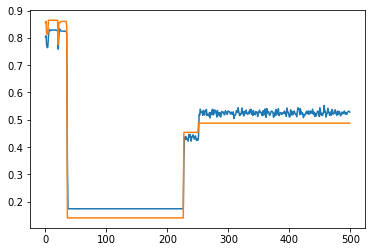

In [29]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.plot(val_acc)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

#es = EarlyStopping(patience=70,monitor= 'val_accuracy')
sgd = SGD(learning_rate=0.2,momentum=0.2)
nn = Sequential()
nn.add(Dense(50,input_dim = xtrain.shape[1]))
nn.add(Dense(400))
nn.add(Dropout(0.35))
nn.add(Dense(400))
nn.add(Dropout(0.35))
nn.add(Dense(1,activation='relu'))
nn.compile(metrics='accuracy',loss='binary_crossentropy',optimizer=sgd)
model = nn.fit(xtrain,ytrain,epochs=1500,validation_split=0.2,initial_epoch=500)

Epoch 501/1500
 5/30 [====>.........................] - ETA: 0s - loss: 3.9180 - accuracy: 0.7000

2022-06-28 14:26:16.083914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 13ms/step - loss: 3.6926 - accuracy: 0.7489 - val_loss: 2.0893 - val_accuracy: 0.8644
Epoch 502/1500
20/30 [===================>..........] - ETA: 0s - loss: 2.4837 - accuracy: 0.8375

2022-06-28 14:26:16.489339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 7ms/step - loss: 2.5607 - accuracy: 0.8330 - val_loss: 1.9608 - val_accuracy: 0.8729
Epoch 503/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.8958 - accuracy: 0.8106 - val_loss: 5.1166 - val_accuracy: 0.6610
Epoch 504/1500
30/30 [==============================] - 0s 8ms/step - loss: 3.5075 - accuracy: 0.7681 - val_loss: 2.2148 - val_accuracy: 0.8559
Epoch 505/1500
30/30 [==============================] - 0s 8ms/step - loss: 5.5003 - accuracy: 0.6383 - val_loss: 5.7690 - val_accuracy: 0.6144
Epoch 506/1500
30/30 [==============================] - 0s 7ms/step - loss: 4.7537 - accuracy: 0.6894 - val_loss: 3.4383 - val_accuracy: 0.7712
Epoch 507/1500
30/30 [==============================] - 0s 7ms/step - loss: 4.6237 - accuracy: 0.6979 - val_loss: 3.4383 - val_accuracy: 0.7712
Epoch 508/1500
30/30 [==============================] - 0s 7ms/step - loss: 3.7857 - accuracy: 0.7521 - val_loss: 2.5386 - val_accuracy: 0.8347
Epoch 5

Epoch 559/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9496 - accuracy: 0.8085 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 560/1500
30/30 [==============================] - 0s 7ms/step - loss: 3.0471 - accuracy: 0.8021 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 561/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9822 - accuracy: 0.8064 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 562/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9494 - accuracy: 0.8085 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 563/1500
30/30 [==============================] - 0s 7ms/step - loss: 3.0628 - accuracy: 0.8011 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 564/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9007 - accuracy: 0.8117 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 565/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9656 - accuracy: 0.8074 - val_loss: 2.4153 - val_accuracy:

Epoch 616/1500
30/30 [==============================] - 0s 7ms/step - loss: 3.0145 - accuracy: 0.8043 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 617/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9815 - accuracy: 0.8064 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 618/1500
30/30 [==============================] - 0s 7ms/step - loss: 3.0145 - accuracy: 0.8043 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 619/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9985 - accuracy: 0.8053 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 620/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9009 - accuracy: 0.8117 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 621/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9336 - accuracy: 0.8096 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 622/1500
30/30 [==============================] - 0s 7ms/step - loss: 3.1122 - accuracy: 0.7979 - val_loss: 2.4153 - val_accuracy:

Epoch 673/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9983 - accuracy: 0.8053 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 674/1500
30/30 [==============================] - 0s 7ms/step - loss: 3.0149 - accuracy: 0.8043 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 675/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9988 - accuracy: 0.8053 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 676/1500
30/30 [==============================] - 0s 7ms/step - loss: 3.0147 - accuracy: 0.8043 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 677/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9983 - accuracy: 0.8053 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 678/1500
30/30 [==============================] - 0s 7ms/step - loss: 3.0633 - accuracy: 0.8011 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 679/1500
30/30 [==============================] - 0s 8ms/step - loss: 2.9656 - accuracy: 0.8074 - val_loss: 2.4153 - val_accuracy:

Epoch 730/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9979 - accuracy: 0.8053 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 731/1500
30/30 [==============================] - 0s 6ms/step - loss: 3.0469 - accuracy: 0.8021 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 732/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.8685 - accuracy: 0.8138 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 733/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9492 - accuracy: 0.8085 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 734/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9824 - accuracy: 0.8064 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 735/1500
30/30 [==============================] - 0s 8ms/step - loss: 2.9656 - accuracy: 0.8074 - val_loss: 2.4153 - val_accuracy: 0.8432
Epoch 736/1500
30/30 [==============================] - 0s 7ms/step - loss: 2.9009 - accuracy: 0.8117 - val_loss: 2.4153 - val_accuracy:

Epoch 787/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0408 - accuracy: 0.4734 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 788/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.3181 - accuracy: 0.4553 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 789/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0257 - accuracy: 0.4745 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 790/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.2197 - accuracy: 0.4617 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 791/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1063 - accuracy: 0.4691 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 792/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.3500 - accuracy: 0.4532 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 793/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.2519 - accuracy: 0.4596 - val_loss: 8.0138 - val_accuracy:

Epoch 844/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0742 - accuracy: 0.4713 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 845/1500
30/30 [==============================] - 0s 7ms/step - loss: 7.9754 - accuracy: 0.4777 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 846/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0897 - accuracy: 0.4702 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 847/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0572 - accuracy: 0.4723 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 848/1500
30/30 [==============================] - 0s 7ms/step - loss: 7.9922 - accuracy: 0.4766 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 849/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.3187 - accuracy: 0.4553 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 850/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1061 - accuracy: 0.4691 - val_loss: 8.0138 - val_accuracy:

Epoch 901/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.2036 - accuracy: 0.4628 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 902/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.2687 - accuracy: 0.4585 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 903/1500
30/30 [==============================] - 0s 7ms/step - loss: 7.8792 - accuracy: 0.4840 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 904/1500
30/30 [==============================] - 0s 6ms/step - loss: 7.9428 - accuracy: 0.4798 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 905/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1701 - accuracy: 0.4649 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 906/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.2357 - accuracy: 0.4606 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 907/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0572 - accuracy: 0.4723 - val_loss: 8.0138 - val_accuracy:

Epoch 958/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0899 - accuracy: 0.4702 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 959/1500
30/30 [==============================] - 0s 7ms/step - loss: 7.7971 - accuracy: 0.4894 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 960/1500
30/30 [==============================] - 0s 6ms/step - loss: 7.8122 - accuracy: 0.4883 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 961/1500
30/30 [==============================] - 0s 6ms/step - loss: 8.2206 - accuracy: 0.4617 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 962/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1055 - accuracy: 0.4691 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 963/1500
30/30 [==============================] - 0s 7ms/step - loss: 7.9603 - accuracy: 0.4787 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 964/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.2680 - accuracy: 0.4585 - val_loss: 8.0138 - val_accuracy:

Epoch 1015/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1714 - accuracy: 0.4649 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1016/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1218 - accuracy: 0.4681 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1017/1500
30/30 [==============================] - 0s 8ms/step - loss: 8.0571 - accuracy: 0.4723 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1018/1500
30/30 [==============================] - 0s 8ms/step - loss: 7.8620 - accuracy: 0.4851 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1019/1500
30/30 [==============================] - 0s 8ms/step - loss: 8.3015 - accuracy: 0.4564 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1020/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.2031 - accuracy: 0.4628 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1021/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1710 - accuracy: 0.4649 - val_loss: 8.0138 - val_ac

30/30 [==============================] - 0s 7ms/step - loss: 8.2031 - accuracy: 0.4628 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1128/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0565 - accuracy: 0.4723 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1129/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1714 - accuracy: 0.4649 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1130/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0891 - accuracy: 0.4702 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1131/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1548 - accuracy: 0.4660 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1132/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.2680 - accuracy: 0.4585 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1133/1500
30/30 [==============================] - 0s 6ms/step - loss: 8.1389 - accuracy: 0.4670 - val_loss: 8.0138 - val_accuracy: 0.4746
E

30/30 [==============================] - 0s 7ms/step - loss: 8.1376 - accuracy: 0.4670 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1240/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1063 - accuracy: 0.4691 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1241/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1699 - accuracy: 0.4649 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1242/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0252 - accuracy: 0.4745 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1243/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.3017 - accuracy: 0.4564 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1244/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.2840 - accuracy: 0.4574 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1245/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.4311 - accuracy: 0.4479 - val_loss: 8.0138 - val_accuracy: 0.4746
E

30/30 [==============================] - 0s 7ms/step - loss: 8.2021 - accuracy: 0.4628 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1352/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0561 - accuracy: 0.4723 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1353/1500
30/30 [==============================] - 0s 7ms/step - loss: 7.8454 - accuracy: 0.4862 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1354/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1544 - accuracy: 0.4660 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1355/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0078 - accuracy: 0.4755 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1356/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1710 - accuracy: 0.4649 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1357/1500
30/30 [==============================] - 0s 7ms/step - loss: 7.9594 - accuracy: 0.4787 - val_loss: 8.0138 - val_accuracy: 0.4746
E

30/30 [==============================] - 0s 7ms/step - loss: 8.3008 - accuracy: 0.4564 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1464/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.2193 - accuracy: 0.4617 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1465/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.1382 - accuracy: 0.4670 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1466/1500
30/30 [==============================] - 0s 7ms/step - loss: 8.0735 - accuracy: 0.4713 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1467/1500
30/30 [==============================] - 0s 7ms/step - loss: 7.8937 - accuracy: 0.4830 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1468/1500
30/30 [==============================] - 0s 7ms/step - loss: 7.9754 - accuracy: 0.4777 - val_loss: 8.0138 - val_accuracy: 0.4746
Epoch 1469/1500
30/30 [==============================] - 0s 7ms/step - loss: 7.9271 - accuracy: 0.4809 - val_loss: 8.0138 - val_accuracy: 0.4746
E

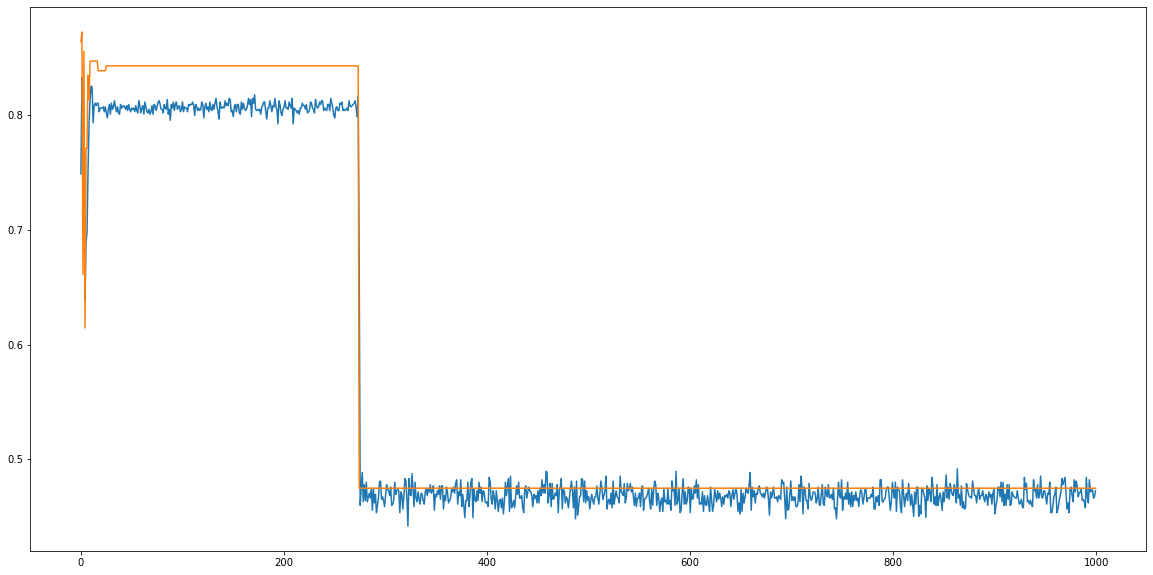

In [32]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(acc)
plt.plot(val_acc)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

#es = EarlyStopping(patience=70,monitor= 'val_accuracy')
sgd = SGD(learning_rate=0.2,momentum=0.2)
nn = Sequential()
nn.add(Dense(50,input_dim = xtrain.shape[1]))
nn.add(Dense(400))
nn.add(Dropout(0.35))
nn.add(Dense(400))
nn.add(Dropout(0.35))
nn.add(Dense(1,activation='relu'))
nn.compile(metrics='accuracy',loss='binary_crossentropy',optimizer=sgd)
model = nn.fit(xtrain,ytrain,epochs=1750,validation_split=0.2,initial_epoch=1500)

Epoch 1501/1750
 8/30 [=======>......................] - ETA: 0s - loss: 2.9982 - accuracy: 0.7773

2022-06-28 14:33:26.711372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 12ms/step - loss: 2.9982 - accuracy: 0.7968 - val_loss: 2.1578 - val_accuracy: 0.8602
Epoch 1502/1750
20/30 [===================>..........] - ETA: 0s - loss: 2.7935 - accuracy: 0.8188

2022-06-28 14:33:27.082451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 7ms/step - loss: 2.7693 - accuracy: 0.8202 - val_loss: 2.6789 - val_accuracy: 0.8220
Epoch 1503/1750
30/30 [==============================] - 0s 7ms/step - loss: 2.9986 - accuracy: 0.8021 - val_loss: 2.1609 - val_accuracy: 0.8559
Epoch 1504/1750
30/30 [==============================] - 0s 7ms/step - loss: 2.6089 - accuracy: 0.8309 - val_loss: 2.1609 - val_accuracy: 0.8559
Epoch 1505/1750
30/30 [==============================] - 0s 7ms/step - loss: 3.1738 - accuracy: 0.7915 - val_loss: 3.6304 - val_accuracy: 0.7627
Epoch 1506/1750
30/30 [==============================] - 0s 8ms/step - loss: 4.8023 - accuracy: 0.6809 - val_loss: 3.4630 - val_accuracy: 0.7669
Epoch 1507/1750
30/30 [==============================] - 0s 8ms/step - loss: 3.0148 - accuracy: 0.8032 - val_loss: 2.0908 - val_accuracy: 0.8644
Epoch 1508/1750
30/30 [==============================] - 0s 7ms/step - loss: 2.8040 - accuracy: 0.8181 - val_loss: 2.0908 - val_accuracy: 0.8644
E

30/30 [==============================] - 0s 7ms/step - loss: 8.0916 - accuracy: 0.4702 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1615/1750
30/30 [==============================] - 0s 7ms/step - loss: 8.0593 - accuracy: 0.4723 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1616/1750
30/30 [==============================] - 0s 7ms/step - loss: 7.7190 - accuracy: 0.4947 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1617/1750
30/30 [==============================] - 0s 7ms/step - loss: 8.2064 - accuracy: 0.4628 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1618/1750
30/30 [==============================] - 0s 7ms/step - loss: 8.2057 - accuracy: 0.4628 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1619/1750
30/30 [==============================] - 0s 7ms/step - loss: 7.4585 - accuracy: 0.5117 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1620/1750
30/30 [==============================] - 0s 7ms/step - loss: 8.0110 - accuracy: 0.4755 - val_loss: 10.1528 - val_accuracy: 0

Epoch 1670/1750
30/30 [==============================] - 0s 7ms/step - loss: 7.7022 - accuracy: 0.4957 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1671/1750
30/30 [==============================] - 0s 7ms/step - loss: 8.2708 - accuracy: 0.4585 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1672/1750
30/30 [==============================] - 0s 7ms/step - loss: 8.3698 - accuracy: 0.4521 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1673/1750
30/30 [==============================] - 0s 7ms/step - loss: 7.9316 - accuracy: 0.4809 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1674/1750
30/30 [==============================] - 0s 7ms/step - loss: 8.3843 - accuracy: 0.4511 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1675/1750
30/30 [==============================] - 0s 7ms/step - loss: 7.8493 - accuracy: 0.4862 - val_loss: 10.1528 - val_accuracy: 0.3347
Epoch 1676/1750
30/30 [==============================] - 0s 7ms/step - loss: 8.2702 - accuracy: 0.4585 - val_loss: 10.1528 -

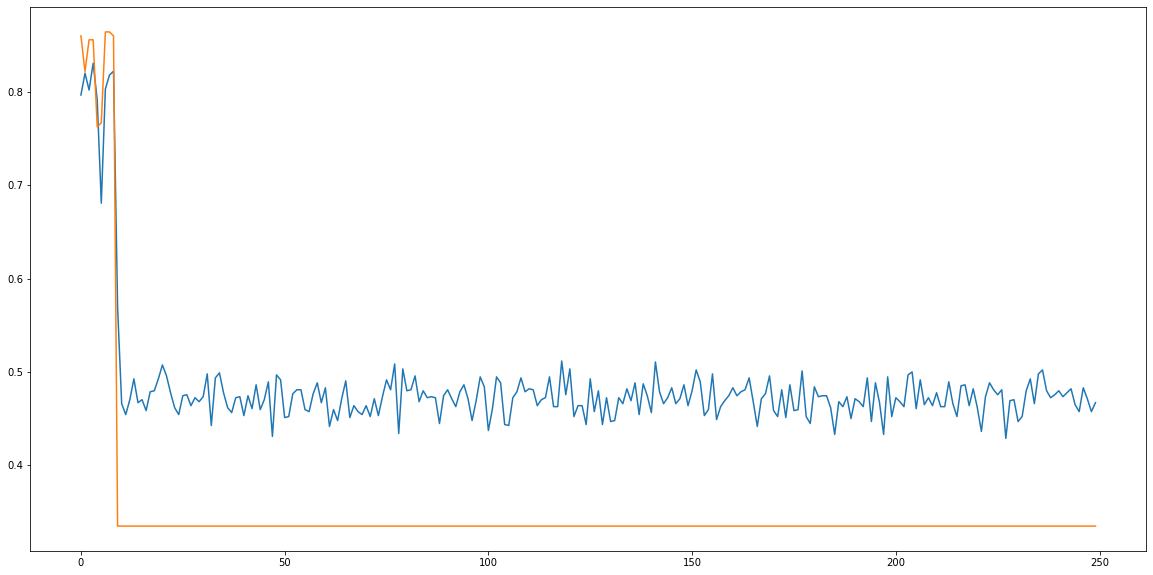

In [34]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(acc)
plt.plot(val_acc)

In [46]:
%%time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.1,momentum=1)
nn = Sequential()
nn.add(Dense(50,input_dim = xtrain.shape[1]))
nn.add(Dense(400))
nn.add(Dropout(0.4))
nn.add(Dense(400))
nn.add(Dropout(0.4))
nn.add(Dense(1 ,activation='sigmoid'))
nn.compile(loss='binary_crossentropy',metrics='accuracy',optimizer =sgd)
model = nn.fit(xtrain,ytrain,epochs=50,validation_split=0.2)

Epoch 1/50
 7/30 [======>.......................] - ETA: 0s - loss: 0.6022 - accuracy: 0.7589

2022-06-28 14:46:24.921690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 13ms/step - loss: nan - accuracy: 0.7383 - val_loss: nan - val_accuracy: 0.8602
Epoch 2/50
10/30 [=========>....................] - ETA: 0s - loss: nan - accuracy: 0.8063

2022-06-28 14:46:25.292914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: n

In [50]:
%%time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

#sgd = SGD(learning_rate=0.1,momentum=1)
nn = Sequential()
nn.add(Dense(50,input_dim = xtrain.shape[1]))
nn.add(Dense(400))
nn.add(Dropout(0.4))
nn.add(Dense(400))
nn.add(Dropout(0.4))
nn.add(Dense(1 ,activation='sigmoid'))
nn.compile(loss='binary_crossentropy',metrics='accuracy',optimizer =sgd)
model = nn.fit(xtrain,ytrain,epochs=50,validation_split=0.2,batch_size =5)

Epoch 1/50


2022-06-28 14:48:20.380039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


179/188 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.8101

2022-06-28 14:48:21.819958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 2s 9ms/step - loss: nan - accuracy: 0.8117 - val_loss: nan - val_accuracy: 0.8602
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 3/50
188/188 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 4/50
188/188 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 5/50
188/188 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 6/50
188/188 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 7/50
188/188 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.8277 - val_loss: nan - val_accuracy: 0.8602
Epoch 8/50
188/188 [==============================] - 1s 5m

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nn = Sequential()
nn.add(Dense(30,input_dim=(55)))
nn.add(Dense(100))
nn.add(Dense(100))
nn.add(Dense(1,activation='sigmoid'))
nn.compile(loss=['binary_crossentropy'],metrics=['accuracy'])
model = nn.fit(xtrain,ytrain,epochs=50)

# acc = model.history['accuracy']
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,10))
# plt.plot(acc)

Epoch 1/50
 1/37 [..............................] - ETA: 11s - loss: 0.7854 - accuracy: 0.5625

2022-06-28 14:09:05.559351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 8ms/step - loss: 0.4154 - accuracy: 0.8308
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.3396 - accuracy: 0.8665
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.3295 - accuracy: 0.8827
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.3230 - accuracy: 0.8750
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.3177 - accuracy: 0.8810
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.3166 - accuracy: 0.8793
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.3182 - accuracy: 0.8784
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.3116 - accuracy: 0.8784
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.3103 - accuracy: 0.8818
Epoch 10/50
37/37 [==============================] - 0s 7ms/step - loss: 0.3153 - accuracy: 0.8844
Epoch 11/50
37/37 [===========

## NN using Dropout

Epoch 1/50
 8/37 [=====>........................] - ETA: 0s - loss: 0.6095 - accuracy: 0.7070

2022-06-24 11:54:04.577412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 9ms/step - loss: 0.4577 - accuracy: 0.8070
Epoch 2/50
37/37 [==============================] - 0s 8ms/step - loss: 0.3993 - accuracy: 0.8444
Epoch 3/50
37/37 [==============================] - 0s 9ms/step - loss: 0.3776 - accuracy: 0.8597
Epoch 4/50
37/37 [==============================] - 0s 9ms/step - loss: 0.3637 - accuracy: 0.8639
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.3594 - accuracy: 0.8512
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.3525 - accuracy: 0.8690
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.3342 - accuracy: 0.8639
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.3389 - accuracy: 0.8665
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.3347 - accuracy: 0.8716
Epoch 10/50
37/37 [==============================] - 0s 9ms/step - loss: 0.3401 - accuracy: 0.8690
Epoch 11/50
37/37 [===========

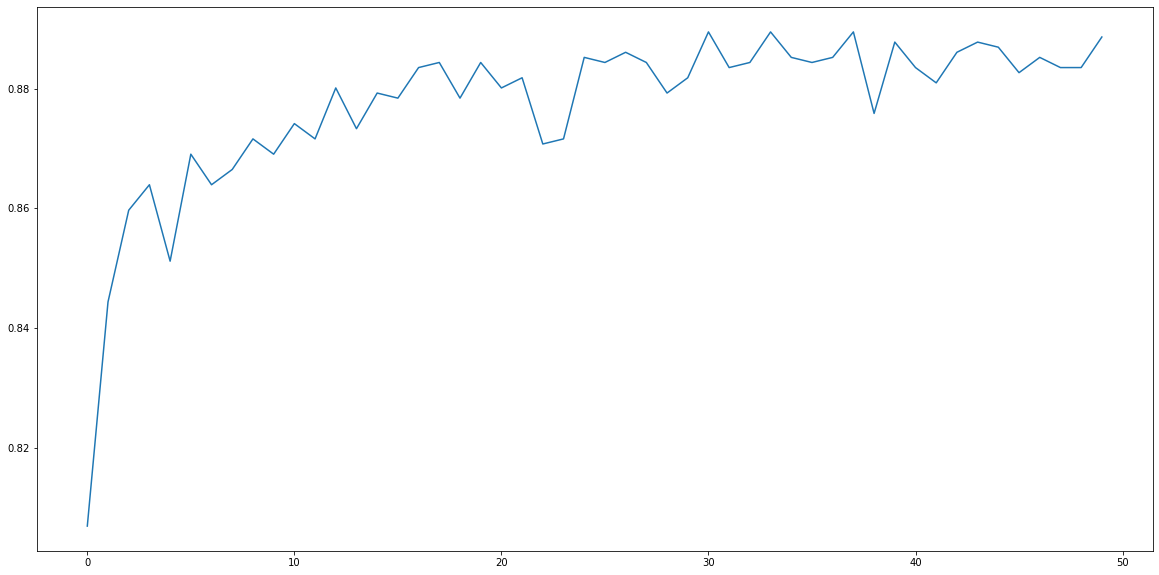

In [1114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

nn = Sequential()
nn.add(Dense(30,input_dim=(55)))
nn.add(Dropout(0.2))
nn.add(Dropout(0.2))
nn.add(Dense(100))
nn.add(Dense(100))
nn.add(Dense(1,activation='sigmoid'))
nn.compile(loss=['binary_crossentropy'],metrics=['accuracy'])
model = nn.fit(xtrain,ytrain,epochs=50)

acc = model.history['accuracy']
plt.figure(figsize=(20,10))
plt.plot(acc)

## NN usning Dropout and validation split

Epoch 1/50
 8/30 [=======>......................] - ETA: 0s - loss: 0.5921 - accuracy: 0.6797

2022-06-24 11:56:19.363755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 14ms/step - loss: 0.4777 - accuracy: 0.7862 - val_loss: 0.3448 - val_accuracy: 0.8814
Epoch 2/50
14/30 [=============>................] - ETA: 0s - loss: 0.4207 - accuracy: 0.8348

2022-06-24 11:56:19.824728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 9ms/step - loss: 0.4148 - accuracy: 0.8309 - val_loss: 0.3361 - val_accuracy: 0.8814
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.3803 - accuracy: 0.8426 - val_loss: 0.3333 - val_accuracy: 0.8898
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.3851 - accuracy: 0.8447 - val_loss: 0.3508 - val_accuracy: 0.8644
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.3813 - accuracy: 0.8489 - val_loss: 0.3344 - val_accuracy: 0.8814
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.3667 - accuracy: 0.8543 - val_loss: 0.3241 - val_accuracy: 0.8898
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.3530 - accuracy: 0.8543 - val_loss: 0.3379 - val_accuracy: 0.8856
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.3394 - accuracy: 0.8649 - val_loss: 0.3346 - val_accuracy: 0.8856
Epoch 9/50
30/30 [===========

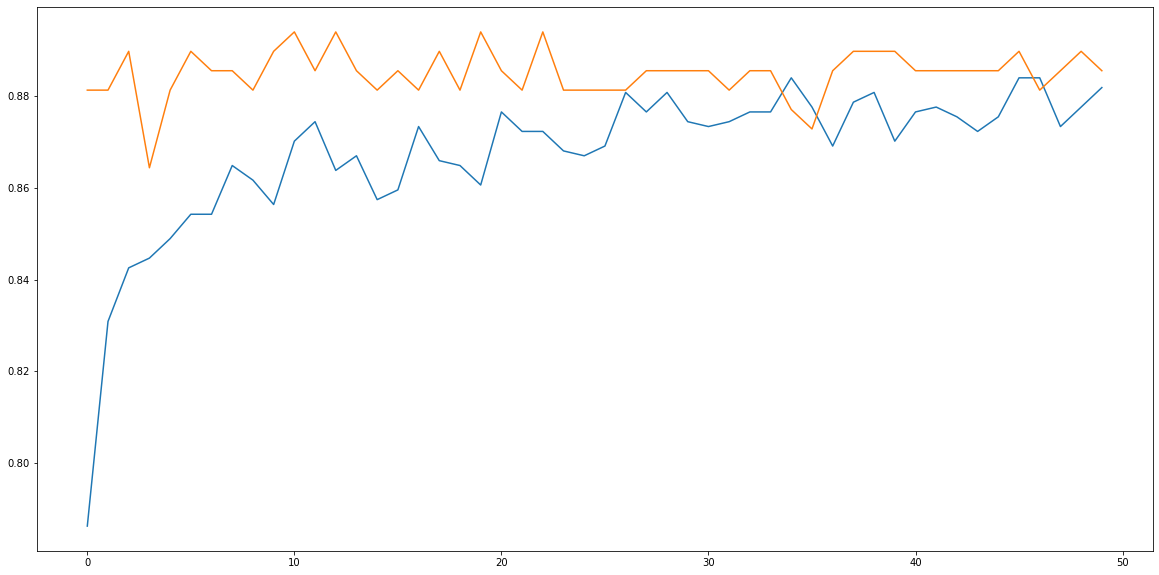

In [1117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

nn = Sequential()
nn.add(Dense(30,input_dim=(55)))
nn.add(Dropout(0.2))
nn.add(Dropout(0.2))
nn.add(Dense(100))
nn.add(Dense(100))
nn.add(Dense(1,activation='sigmoid'))
nn.compile(loss=['binary_crossentropy'],metrics=['accuracy'])
model = nn.fit(xtrain,ytrain,epochs=50,validation_split=0.2)

acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
plt.figure(figsize=(20,10))
plt.plot(acc)
plt.plot(val_acc)

## NN with high number of epochs

Epoch 1/500
 8/30 [=======>......................] - ETA: 0s - loss: 0.5402 - accuracy: 0.7734

2022-06-24 11:59:27.658369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 14ms/step - loss: 0.4939 - accuracy: 0.8011 - val_loss: 0.3413 - val_accuracy: 0.8856
Epoch 2/500
15/30 [==============>...............] - ETA: 0s - loss: 0.4253 - accuracy: 0.8229

2022-06-24 11:59:28.123285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 9ms/step - loss: 0.4288 - accuracy: 0.8245 - val_loss: 0.3575 - val_accuracy: 0.8729
Epoch 3/500
30/30 [==============================] - 0s 9ms/step - loss: 0.4130 - accuracy: 0.8309 - val_loss: 0.3325 - val_accuracy: 0.8729
Epoch 4/500
30/30 [==============================] - 0s 9ms/step - loss: 0.4036 - accuracy: 0.8415 - val_loss: 0.3136 - val_accuracy: 0.8856
Epoch 5/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3854 - accuracy: 0.8479 - val_loss: 0.3270 - val_accuracy: 0.8941
Epoch 6/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3789 - accuracy: 0.8521 - val_loss: 0.3233 - val_accuracy: 0.8898
Epoch 7/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3686 - accuracy: 0.8564 - val_loss: 0.3128 - val_accuracy: 0.8814
Epoch 8/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3476 - accuracy: 0.8713 - val_loss: 0.3107 - val_accuracy: 0.8814
Epoch 9/500
30/30 [======

Epoch 60/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3064 - accuracy: 0.8755 - val_loss: 0.3234 - val_accuracy: 0.8814
Epoch 61/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3106 - accuracy: 0.8755 - val_loss: 0.3140 - val_accuracy: 0.8856
Epoch 62/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3053 - accuracy: 0.8681 - val_loss: 0.3183 - val_accuracy: 0.8856
Epoch 63/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3064 - accuracy: 0.8787 - val_loss: 0.3365 - val_accuracy: 0.8856
Epoch 64/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3108 - accuracy: 0.8787 - val_loss: 0.3134 - val_accuracy: 0.8814
Epoch 65/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3090 - accuracy: 0.8830 - val_loss: 0.3242 - val_accuracy: 0.8814
Epoch 66/500
30/30 [==============================] - 0s 9ms/step - loss: 0.3033 - accuracy: 0.8745 - val_loss: 0.3175 - val_accuracy: 0.8856
Epoch 

30/30 [==============================] - 0s 10ms/step - loss: 0.2861 - accuracy: 0.8840 - val_loss: 0.3299 - val_accuracy: 0.8898
Epoch 175/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2958 - accuracy: 0.8766 - val_loss: 0.3307 - val_accuracy: 0.8814
Epoch 176/500
30/30 [==============================] - 0s 10ms/step - loss: 0.2924 - accuracy: 0.8809 - val_loss: 0.3196 - val_accuracy: 0.8856
Epoch 177/500
30/30 [==============================] - 0s 10ms/step - loss: 0.2924 - accuracy: 0.8872 - val_loss: 0.3194 - val_accuracy: 0.8814
Epoch 178/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2916 - accuracy: 0.8840 - val_loss: 0.3340 - val_accuracy: 0.8856
Epoch 179/500
30/30 [==============================] - 0s 10ms/step - loss: 0.2863 - accuracy: 0.8883 - val_loss: 0.3364 - val_accuracy: 0.8856
Epoch 180/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2878 - accuracy: 0.8809 - val_loss: 0.3274 - val_accuracy: 0.8856
Epoch 181

30/30 [==============================] - 0s 9ms/step - loss: 0.2886 - accuracy: 0.8904 - val_loss: 0.3294 - val_accuracy: 0.8898
Epoch 289/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2865 - accuracy: 0.8894 - val_loss: 0.3205 - val_accuracy: 0.8814
Epoch 290/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2868 - accuracy: 0.8830 - val_loss: 0.3241 - val_accuracy: 0.8898
Epoch 291/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2912 - accuracy: 0.8798 - val_loss: 0.3291 - val_accuracy: 0.8856
Epoch 292/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2883 - accuracy: 0.8862 - val_loss: 0.3376 - val_accuracy: 0.8856
Epoch 293/500
30/30 [==============================] - 0s 10ms/step - loss: 0.2902 - accuracy: 0.8926 - val_loss: 0.3283 - val_accuracy: 0.8814
Epoch 294/500
30/30 [==============================] - 0s 10ms/step - loss: 0.2934 - accuracy: 0.8809 - val_loss: 0.3338 - val_accuracy: 0.8814
Epoch 295/5

30/30 [==============================] - 0s 9ms/step - loss: 0.2877 - accuracy: 0.8894 - val_loss: 0.3166 - val_accuracy: 0.8941
Epoch 403/500
30/30 [==============================] - 0s 10ms/step - loss: 0.2882 - accuracy: 0.8840 - val_loss: 0.3353 - val_accuracy: 0.8941
Epoch 404/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2882 - accuracy: 0.8840 - val_loss: 0.3283 - val_accuracy: 0.8941
Epoch 405/500
30/30 [==============================] - 0s 10ms/step - loss: 0.2868 - accuracy: 0.8862 - val_loss: 0.3475 - val_accuracy: 0.8941
Epoch 406/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2880 - accuracy: 0.8936 - val_loss: 0.3357 - val_accuracy: 0.8856
Epoch 407/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2879 - accuracy: 0.8883 - val_loss: 0.3236 - val_accuracy: 0.8941
Epoch 408/500
30/30 [==============================] - 0s 9ms/step - loss: 0.2862 - accuracy: 0.8883 - val_loss: 0.3360 - val_accuracy: 0.8941
Epoch 409/5

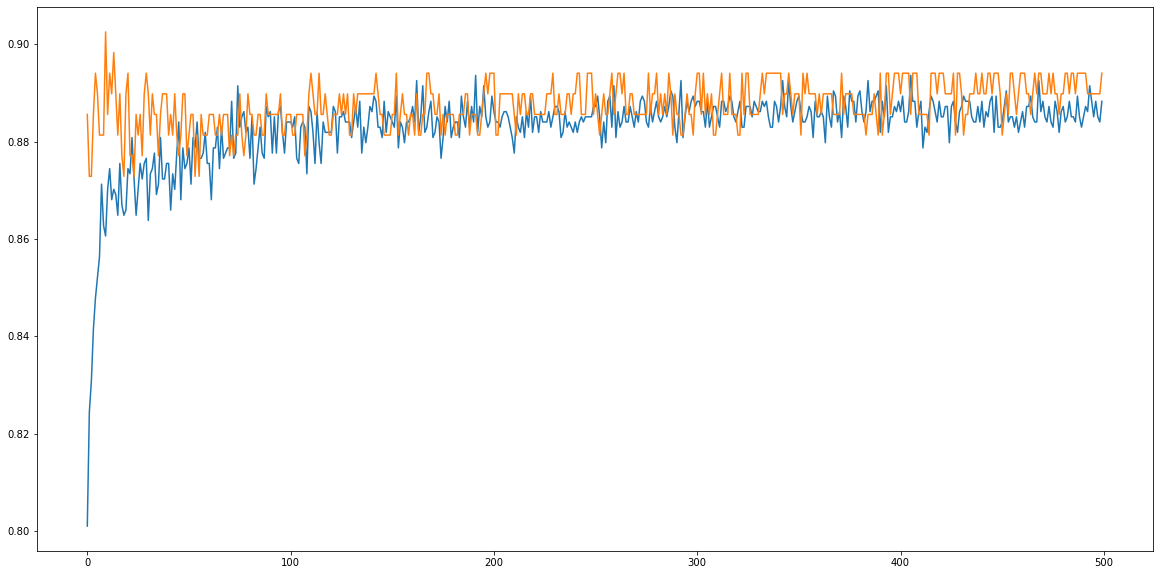

In [1118]:
%%time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

nn = Sequential()
nn.add(Dense(30,input_dim=(55)))
nn.add(Dropout(0.2))
nn.add(Dropout(0.2))
nn.add(Dense(100))
nn.add(Dense(100))
nn.add(Dense(1,activation='sigmoid'))
nn.compile(loss=['binary_crossentropy'],metrics=['accuracy'])
model = nn.fit(xtrain,ytrain,epochs=500,validation_split=0.2)

acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
plt.figure(figsize=(20,10))
plt.plot(acc)
plt.plot(val_acc)

## NN Dropout Better Graph Plotting

Epoch 1/200
 1/30 [>.............................] - ETA: 8s - loss: 0.9271 - accuracy: 0.4375

2022-06-24 12:17:33.874667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 18ms/step - loss: 0.4762 - accuracy: 0.7968 - val_loss: 0.3520 - val_accuracy: 0.8729
Epoch 2/200
 7/30 [======>.......................] - ETA: 0s - loss: 0.4482 - accuracy: 0.8036

2022-06-24 12:17:34.456113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 10ms/step - loss: 0.4255 - accuracy: 0.8309 - val_loss: 0.3357 - val_accuracy: 0.8644
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3985 - accuracy: 0.8457 - val_loss: 0.3293 - val_accuracy: 0.8644
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3823 - accuracy: 0.8436 - val_loss: 0.3265 - val_accuracy: 0.8856
Epoch 5/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3756 - accuracy: 0.8500 - val_loss: 0.3336 - val_accuracy: 0.8814
Epoch 6/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3576 - accuracy: 0.8691 - val_loss: 0.3322 - val_accuracy: 0.8898
Epoch 7/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3600 - accuracy: 0.8447 - val_loss: 0.3186 - val_accuracy: 0.8983
Epoch 8/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3395 - accuracy: 0.8670 - val_loss: 0.3250 - val_accuracy: 0.8941
Epoch 9/200
30/30 [=====

Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3025 - accuracy: 0.8872 - val_loss: 0.3314 - val_accuracy: 0.8856
Epoch 61/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3048 - accuracy: 0.8809 - val_loss: 0.3190 - val_accuracy: 0.8941
Epoch 62/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2918 - accuracy: 0.8809 - val_loss: 0.3310 - val_accuracy: 0.8856
Epoch 63/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3004 - accuracy: 0.8755 - val_loss: 0.3342 - val_accuracy: 0.8814
Epoch 64/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2927 - accuracy: 0.8787 - val_loss: 0.3341 - val_accuracy: 0.8898
Epoch 65/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3055 - accuracy: 0.8755 - val_loss: 0.3175 - val_accuracy: 0.8898
Epoch 66/200
30/30 [==============================] - 0s 9ms/step - loss: 0.3071 - accuracy: 0.8734 - val_loss: 0.3206 - val_accuracy: 0.8771
Epoch 

30/30 [==============================] - 0s 9ms/step - loss: 0.2922 - accuracy: 0.8862 - val_loss: 0.3195 - val_accuracy: 0.8898
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2866 - accuracy: 0.8809 - val_loss: 0.3379 - val_accuracy: 0.8856
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2987 - accuracy: 0.8872 - val_loss: 0.3284 - val_accuracy: 0.8856
Epoch 177/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2889 - accuracy: 0.8872 - val_loss: 0.3188 - val_accuracy: 0.8898
Epoch 178/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2911 - accuracy: 0.8872 - val_loss: 0.3270 - val_accuracy: 0.8856
Epoch 179/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2960 - accuracy: 0.8830 - val_loss: 0.3192 - val_accuracy: 0.8856
Epoch 180/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2890 - accuracy: 0.8819 - val_loss: 0.3198 - val_accuracy: 0.8898
Epoch 181/

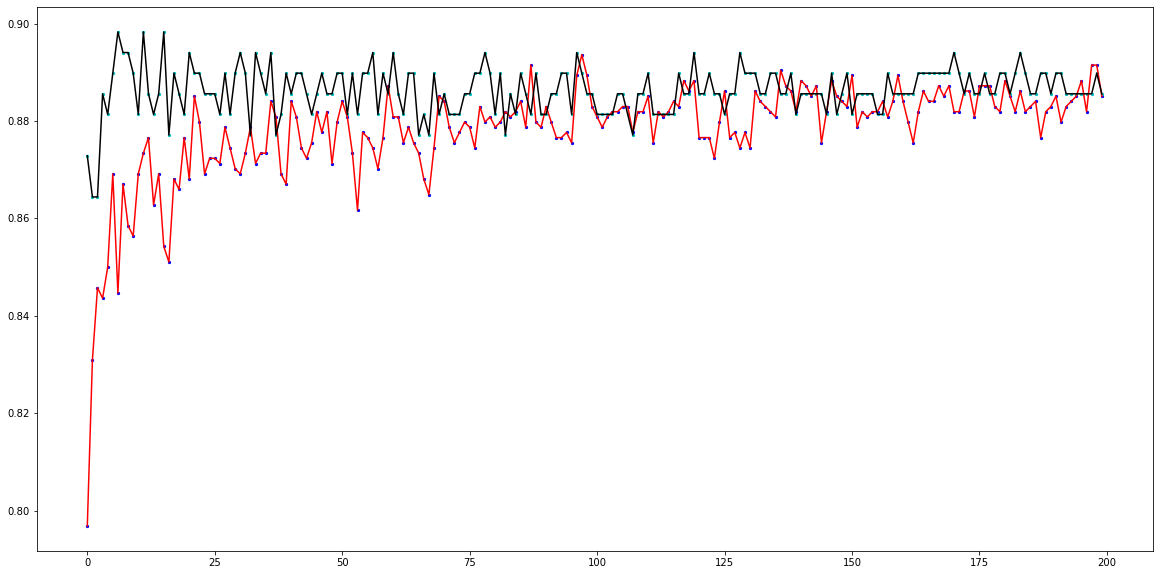

In [1138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

nn = Sequential()
nn.add(Dense(30,input_dim=(55)))
nn.add(Dropout(0.2))
nn.add(Dropout(0.2))
nn.add(Dense(100))
nn.add(Dense(100))
nn.add(Dense(1,activation='sigmoid'))
nn.compile(loss=['binary_crossentropy'],metrics=['accuracy'])
model = nn.fit(xtrain,ytrain,epochs=200,validation_split=0.2)

acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
a = range(0,(len(model.epoch)))
# plt.plot(acc,'ro')
plt.plot(a,acc,c='r')
plt.plot(a,val_acc,c='k')
plt.scatter(a,acc,c='b',s=5)
plt.scatter(a,val_acc,c='c',s=5)

## NN with SGD with momentum 0.2

Epoch 1/500


2022-06-24 12:38:57.974164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 15ms/step - loss: 0.5656 - accuracy: 0.7362 - val_loss: 0.4323 - val_accuracy: 0.8559
Epoch 2/500
 9/30 [========>.....................] - ETA: 0s - loss: 0.4563 - accuracy: 0.8160

2022-06-24 12:38:58.699803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 7ms/step - loss: 0.4530 - accuracy: 0.8191 - val_loss: 0.3894 - val_accuracy: 0.8517
Epoch 3/500
30/30 [==============================] - 0s 7ms/step - loss: 0.4176 - accuracy: 0.8277 - val_loss: 0.3818 - val_accuracy: 0.8517
Epoch 4/500
30/30 [==============================] - 0s 8ms/step - loss: 0.4093 - accuracy: 0.8319 - val_loss: 0.3746 - val_accuracy: 0.8517
Epoch 5/500
30/30 [==============================] - 0s 7ms/step - loss: 0.4113 - accuracy: 0.8213 - val_loss: 0.3687 - val_accuracy: 0.8517
Epoch 6/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3931 - accuracy: 0.8372 - val_loss: 0.3623 - val_accuracy: 0.8602
Epoch 7/500
30/30 [==============================] - 0s 7ms/step - loss: 0.4025 - accuracy: 0.8383 - val_loss: 0.3605 - val_accuracy: 0.8559
Epoch 8/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3868 - accuracy: 0.8500 - val_loss: 0.3492 - val_accuracy: 0.8686
Epoch 9/500
30/30 [======

30/30 [==============================] - 0s 7ms/step - loss: 0.3077 - accuracy: 0.8755 - val_loss: 0.3237 - val_accuracy: 0.8771
Epoch 117/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3031 - accuracy: 0.8755 - val_loss: 0.3235 - val_accuracy: 0.8771
Epoch 118/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3185 - accuracy: 0.8798 - val_loss: 0.3254 - val_accuracy: 0.8814
Epoch 119/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3129 - accuracy: 0.8702 - val_loss: 0.3255 - val_accuracy: 0.8771
Epoch 120/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3204 - accuracy: 0.8713 - val_loss: 0.3248 - val_accuracy: 0.8771
Epoch 121/500
30/30 [==============================] - 0s 8ms/step - loss: 0.3079 - accuracy: 0.8777 - val_loss: 0.3263 - val_accuracy: 0.8814
Epoch 122/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3050 - accuracy: 0.8723 - val_loss: 0.3275 - val_accuracy: 0.8814
Epoch 123/500

30/30 [==============================] - 0s 7ms/step - loss: 0.2936 - accuracy: 0.8819 - val_loss: 0.3274 - val_accuracy: 0.8856
Epoch 231/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3002 - accuracy: 0.8819 - val_loss: 0.3276 - val_accuracy: 0.8856
Epoch 232/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3073 - accuracy: 0.8734 - val_loss: 0.3280 - val_accuracy: 0.8856
Epoch 233/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3041 - accuracy: 0.8851 - val_loss: 0.3277 - val_accuracy: 0.8856
Epoch 234/500
30/30 [==============================] - 0s 7ms/step - loss: 0.3054 - accuracy: 0.8702 - val_loss: 0.3267 - val_accuracy: 0.8856
Epoch 235/500
30/30 [==============================] - 0s 7ms/step - loss: 0.2953 - accuracy: 0.8809 - val_loss: 0.3257 - val_accuracy: 0.8856
Epoch 236/500
30/30 [==============================] - 0s 7ms/step - loss: 0.2991 - accuracy: 0.8787 - val_loss: 0.3266 - val_accuracy: 0.8856
Epoch 237/500

30/30 [==============================] - 0s 7ms/step - loss: 0.3001 - accuracy: 0.8787 - val_loss: 0.3209 - val_accuracy: 0.8898
Epoch 345/500
30/30 [==============================] - 0s 7ms/step - loss: 0.2917 - accuracy: 0.8915 - val_loss: 0.3214 - val_accuracy: 0.8898
Epoch 346/500
30/30 [==============================] - 0s 7ms/step - loss: 0.2985 - accuracy: 0.8787 - val_loss: 0.3183 - val_accuracy: 0.8898
Epoch 347/500
30/30 [==============================] - 0s 7ms/step - loss: 0.2903 - accuracy: 0.8883 - val_loss: 0.3179 - val_accuracy: 0.8898
Epoch 348/500
30/30 [==============================] - 0s 7ms/step - loss: 0.2984 - accuracy: 0.8755 - val_loss: 0.3191 - val_accuracy: 0.8898
Epoch 349/500
30/30 [==============================] - 0s 7ms/step - loss: 0.2943 - accuracy: 0.8830 - val_loss: 0.3220 - val_accuracy: 0.8898
Epoch 350/500
30/30 [==============================] - 0s 7ms/step - loss: 0.2956 - accuracy: 0.8883 - val_loss: 0.3232 - val_accuracy: 0.8898
Epoch 351/500

30/30 [==============================] - 0s 6ms/step - loss: 0.2942 - accuracy: 0.8819 - val_loss: 0.3295 - val_accuracy: 0.8856
Epoch 459/500
30/30 [==============================] - 0s 6ms/step - loss: 0.2901 - accuracy: 0.8798 - val_loss: 0.3287 - val_accuracy: 0.8898
Epoch 460/500
30/30 [==============================] - 0s 6ms/step - loss: 0.2908 - accuracy: 0.8766 - val_loss: 0.3297 - val_accuracy: 0.8856
Epoch 461/500
30/30 [==============================] - 0s 6ms/step - loss: 0.2999 - accuracy: 0.8787 - val_loss: 0.3277 - val_accuracy: 0.8856
Epoch 462/500
30/30 [==============================] - 0s 8ms/step - loss: 0.3045 - accuracy: 0.8755 - val_loss: 0.3255 - val_accuracy: 0.8898
Epoch 463/500
30/30 [==============================] - 0s 6ms/step - loss: 0.2947 - accuracy: 0.8819 - val_loss: 0.3241 - val_accuracy: 0.8898
Epoch 464/500
30/30 [==============================] - 0s 6ms/step - loss: 0.2928 - accuracy: 0.8787 - val_loss: 0.3267 - val_accuracy: 0.8898
Epoch 465/500

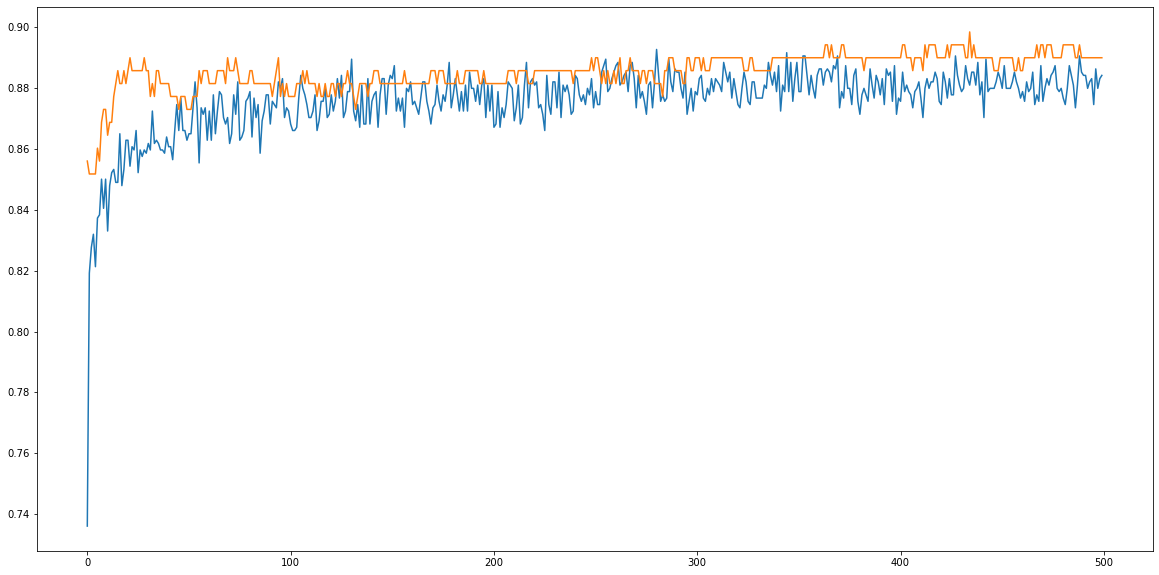

In [1139]:
%%time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
opt = SGD(momentum=0.2)

nn = Sequential()
nn.add(Dense(30,input_dim=(55)))
nn.add(Dropout(0.2))
nn.add(Dropout(0.2))
nn.add(Dense(100))
nn.add(Dense(100))
nn.add(Dense(1,activation='sigmoid'))
nn.compile(loss=['binary_crossentropy'],metrics=['accuracy'],optimizer=opt)
model = nn.fit(xtrain,ytrain,epochs=500,validation_split=0.2)

acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
plt.figure(figsize=(20,10))
plt.plot(acc)
plt.plot(val_acc)

Epoch 1/500


2022-06-24 12:43:41.597923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 21ms/step - loss: 0.6853 - accuracy: 0.6138 - val_loss: 0.4337 - val_accuracy: 0.8475
Epoch 2/500
 9/19 [=============>................] - ETA: 0s - loss: 0.4757 - accuracy: 0.7956

2022-06-24 12:43:42.102440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 8ms/step - loss: 0.4775 - accuracy: 0.7968 - val_loss: 0.3873 - val_accuracy: 0.8644
Epoch 3/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4569 - accuracy: 0.8266 - val_loss: 0.3732 - val_accuracy: 0.8729
Epoch 4/500
19/19 [==============================] - 0s 8ms/step - loss: 0.4450 - accuracy: 0.8170 - val_loss: 0.3642 - val_accuracy: 0.8644
Epoch 5/500
19/19 [==============================] - 0s 8ms/step - loss: 0.4411 - accuracy: 0.8245 - val_loss: 0.3606 - val_accuracy: 0.8771
Epoch 6/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4335 - accuracy: 0.8255 - val_loss: 0.3554 - val_accuracy: 0.8686
Epoch 7/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4299 - accuracy: 0.8383 - val_loss: 0.3501 - val_accuracy: 0.8686
Epoch 8/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4204 - accuracy: 0.8234 - val_loss: 0.3490 - val_accuracy: 0.8729
Epoch 9/500
19/19 [======

Epoch 60/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3396 - accuracy: 0.8649 - val_loss: 0.3107 - val_accuracy: 0.8941
Epoch 61/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3447 - accuracy: 0.8617 - val_loss: 0.3106 - val_accuracy: 0.8941
Epoch 62/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3420 - accuracy: 0.8649 - val_loss: 0.3098 - val_accuracy: 0.8941
Epoch 63/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3530 - accuracy: 0.8564 - val_loss: 0.3098 - val_accuracy: 0.8941
Epoch 64/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3406 - accuracy: 0.8670 - val_loss: 0.3144 - val_accuracy: 0.8941
Epoch 65/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3534 - accuracy: 0.8521 - val_loss: 0.3141 - val_accuracy: 0.8941
Epoch 66/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3323 - accuracy: 0.8596 - val_loss: 0.3123 - val_accuracy: 0.8941
Epoch 

19/19 [==============================] - 0s 6ms/step - loss: 0.3001 - accuracy: 0.8745 - val_loss: 0.3233 - val_accuracy: 0.8856
Epoch 175/500
19/19 [==============================] - 0s 6ms/step - loss: 0.3144 - accuracy: 0.8798 - val_loss: 0.3218 - val_accuracy: 0.8856
Epoch 176/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3085 - accuracy: 0.8745 - val_loss: 0.3206 - val_accuracy: 0.8898
Epoch 177/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3167 - accuracy: 0.8766 - val_loss: 0.3210 - val_accuracy: 0.8856
Epoch 178/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3114 - accuracy: 0.8798 - val_loss: 0.3219 - val_accuracy: 0.8856
Epoch 179/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3194 - accuracy: 0.8723 - val_loss: 0.3202 - val_accuracy: 0.8898
Epoch 180/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3107 - accuracy: 0.8713 - val_loss: 0.3206 - val_accuracy: 0.8856
Epoch 181/500

19/19 [==============================] - 0s 6ms/step - loss: 0.3073 - accuracy: 0.8777 - val_loss: 0.3199 - val_accuracy: 0.8898
Epoch 289/500
19/19 [==============================] - 0s 6ms/step - loss: 0.3013 - accuracy: 0.8830 - val_loss: 0.3204 - val_accuracy: 0.8898
Epoch 290/500
19/19 [==============================] - 0s 6ms/step - loss: 0.2998 - accuracy: 0.8819 - val_loss: 0.3192 - val_accuracy: 0.8898
Epoch 291/500
19/19 [==============================] - 0s 6ms/step - loss: 0.3054 - accuracy: 0.8862 - val_loss: 0.3172 - val_accuracy: 0.8941
Epoch 292/500
19/19 [==============================] - 0s 6ms/step - loss: 0.3013 - accuracy: 0.8766 - val_loss: 0.3185 - val_accuracy: 0.8941
Epoch 293/500
19/19 [==============================] - 0s 6ms/step - loss: 0.3066 - accuracy: 0.8840 - val_loss: 0.3188 - val_accuracy: 0.8898
Epoch 294/500
19/19 [==============================] - 0s 6ms/step - loss: 0.3104 - accuracy: 0.8702 - val_loss: 0.3194 - val_accuracy: 0.8898
Epoch 295/500

19/19 [==============================] - 0s 6ms/step - loss: 0.3039 - accuracy: 0.8777 - val_loss: 0.3201 - val_accuracy: 0.8983
Epoch 403/500
19/19 [==============================] - 0s 9ms/step - loss: 0.3021 - accuracy: 0.8755 - val_loss: 0.3201 - val_accuracy: 0.8983
Epoch 404/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3020 - accuracy: 0.8830 - val_loss: 0.3197 - val_accuracy: 0.8983
Epoch 405/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3002 - accuracy: 0.8830 - val_loss: 0.3199 - val_accuracy: 0.8983
Epoch 406/500
19/19 [==============================] - 0s 6ms/step - loss: 0.2976 - accuracy: 0.8819 - val_loss: 0.3208 - val_accuracy: 0.8983
Epoch 407/500
19/19 [==============================] - 0s 6ms/step - loss: 0.3019 - accuracy: 0.8809 - val_loss: 0.3213 - val_accuracy: 0.8983
Epoch 408/500
19/19 [==============================] - 0s 6ms/step - loss: 0.2926 - accuracy: 0.8830 - val_loss: 0.3240 - val_accuracy: 0.8941
Epoch 409/500

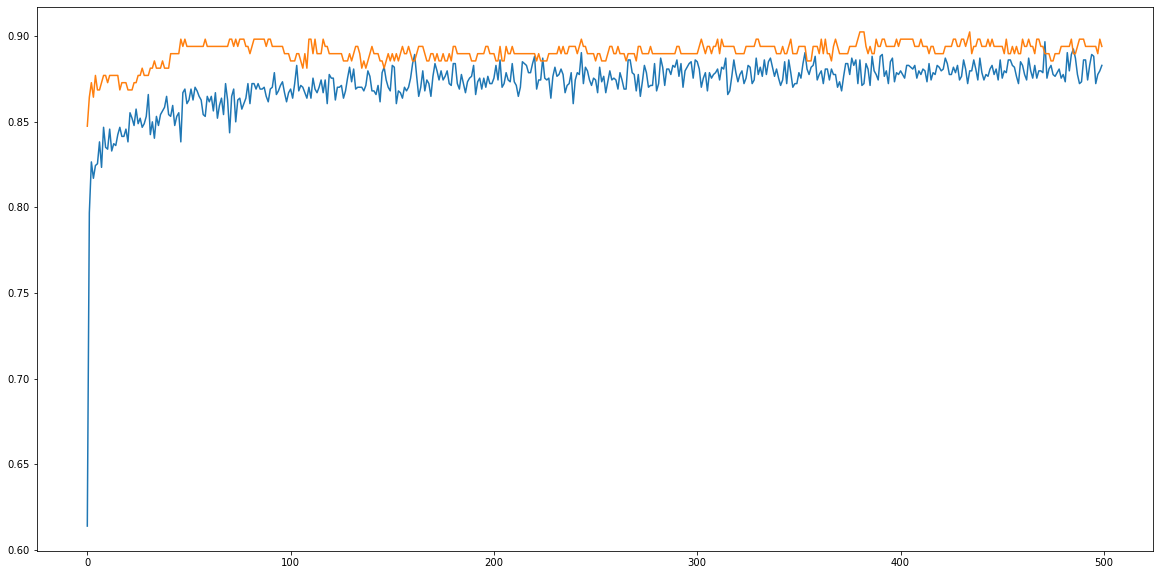

In [1140]:
%%time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

nn = Sequential()
nn.add(Dense(30,input_dim=(55)))
nn.add(Dropout(0.2))
nn.add(Dropout(0.2))
nn.add(Dense(100))
nn.add(Dense(100))
nn.add(Dense(1,activation='sigmoid'))
nn.compile(loss=['binary_crossentropy'],metrics=['accuracy'],optimizer=opt)
model = nn.fit(xtrain,ytrain,epochs=500,validation_split=0.2,batch_size=50)

acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
plt.figure(figsize=(20,10))
plt.plot(acc)
plt.plot(val_acc)

## NN with Early Stopping and Minibatch GD

Epoch 1/500


2022-06-27 20:16:09.660164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 22ms/step - loss: 0.6232 - accuracy: 0.6628 - val_loss: 0.5227 - val_accuracy: 0.8051
Epoch 2/500
 8/19 [===========>..................] - ETA: 0s - loss: 0.4990 - accuracy: 0.7800

2022-06-27 20:16:10.193285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 8ms/step - loss: 0.4729 - accuracy: 0.7957 - val_loss: 0.4545 - val_accuracy: 0.8347
Epoch 3/500
19/19 [==============================] - 0s 8ms/step - loss: 0.4361 - accuracy: 0.8202 - val_loss: 0.4249 - val_accuracy: 0.8475
Epoch 4/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4326 - accuracy: 0.8223 - val_loss: 0.4089 - val_accuracy: 0.8475
Epoch 5/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4152 - accuracy: 0.8255 - val_loss: 0.3961 - val_accuracy: 0.8517
Epoch 6/500
19/19 [==============================] - 0s 8ms/step - loss: 0.3962 - accuracy: 0.8404 - val_loss: 0.3902 - val_accuracy: 0.8559
Epoch 7/500
19/19 [==============================] - 0s 8ms/step - loss: 0.3944 - accuracy: 0.8298 - val_loss: 0.3851 - val_accuracy: 0.8559
Epoch 8/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3882 - accuracy: 0.8372 - val_loss: 0.3776 - val_accuracy: 0.8559
Epoch 9/500
19/19 [======

Epoch 60/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3406 - accuracy: 0.8691 - val_loss: 0.3270 - val_accuracy: 0.8856
Epoch 61/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3285 - accuracy: 0.8617 - val_loss: 0.3255 - val_accuracy: 0.8856
CPU times: user 8.29 s, sys: 5.59 s, total: 13.9 s
Wall time: 9.64 s


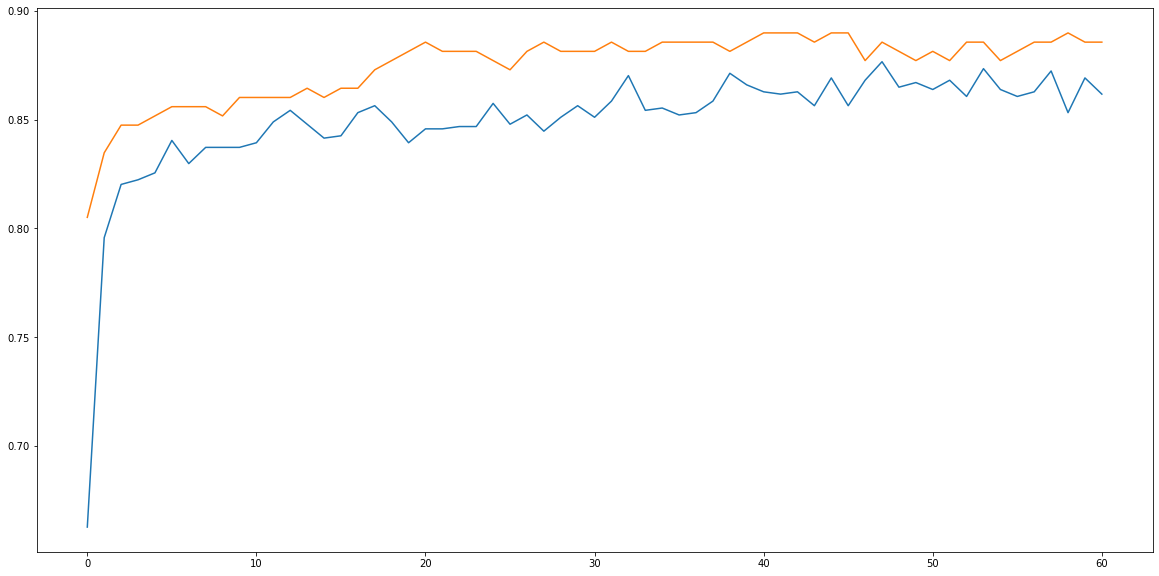

In [1153]:
%%time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=20,monitor = 'val_accuracy')

nn = Sequential()
nn.add(Dense(30,input_dim=(55)))
nn.add(Dropout(0.2))
nn.add(Dropout(0.2))
nn.add(Dense(100))
nn.add(Dense(100))
nn.add(Dense(1,activation='sigmoid'))
nn.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)
model = nn.fit(xtrain,ytrain,epochs=500,validation_split=0.2,batch_size=50,callbacks=es)

acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
plt.figure(figsize=(20,10))
plt.plot(acc)
plt.plot(val_acc)

Epoch 1/500
 1/19 [>.............................] - ETA: 4s - loss: 0.5654 - accuracy: 0.6200

2022-06-24 13:13:51.476436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 22ms/step - loss: 0.5104 - accuracy: 0.7745 - val_loss: 0.3897 - val_accuracy: 0.8517
Epoch 2/500
 8/19 [===========>..................] - ETA: 0s - loss: 0.4558 - accuracy: 0.7975

2022-06-24 13:13:51.927562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 8ms/step - loss: 0.4410 - accuracy: 0.8106 - val_loss: 0.3631 - val_accuracy: 0.8644
Epoch 3/500
19/19 [==============================] - 0s 8ms/step - loss: 0.4234 - accuracy: 0.8362 - val_loss: 0.3480 - val_accuracy: 0.8644
Epoch 4/500
19/19 [==============================] - 0s 8ms/step - loss: 0.4126 - accuracy: 0.8277 - val_loss: 0.3409 - val_accuracy: 0.8644
Epoch 5/500
19/19 [==============================] - 0s 8ms/step - loss: 0.4003 - accuracy: 0.8415 - val_loss: 0.3373 - val_accuracy: 0.8644
Epoch 6/500
19/19 [==============================] - 0s 8ms/step - loss: 0.3927 - accuracy: 0.8394 - val_loss: 0.3342 - val_accuracy: 0.8644
Epoch 7/500
19/19 [==============================] - 0s 8ms/step - loss: 0.3875 - accuracy: 0.8479 - val_loss: 0.3283 - val_accuracy: 0.8644
Epoch 8/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3813 - accuracy: 0.8479 - val_loss: 0.3290 - val_accuracy: 0.8644
Epoch 9/500
19/19 [======

Epoch 60/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3296 - accuracy: 0.8606 - val_loss: 0.3074 - val_accuracy: 0.8856
Epoch 61/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3341 - accuracy: 0.8723 - val_loss: 0.3071 - val_accuracy: 0.8856
Epoch 62/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3393 - accuracy: 0.8660 - val_loss: 0.3080 - val_accuracy: 0.8856
Epoch 63/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3278 - accuracy: 0.8681 - val_loss: 0.3099 - val_accuracy: 0.8856
Epoch 64/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3154 - accuracy: 0.8777 - val_loss: 0.3106 - val_accuracy: 0.8856
Epoch 65/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3254 - accuracy: 0.8766 - val_loss: 0.3136 - val_accuracy: 0.8856
Epoch 66/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3325 - accuracy: 0.8606 - val_loss: 0.3112 - val_accuracy: 0.8814
Epoch 

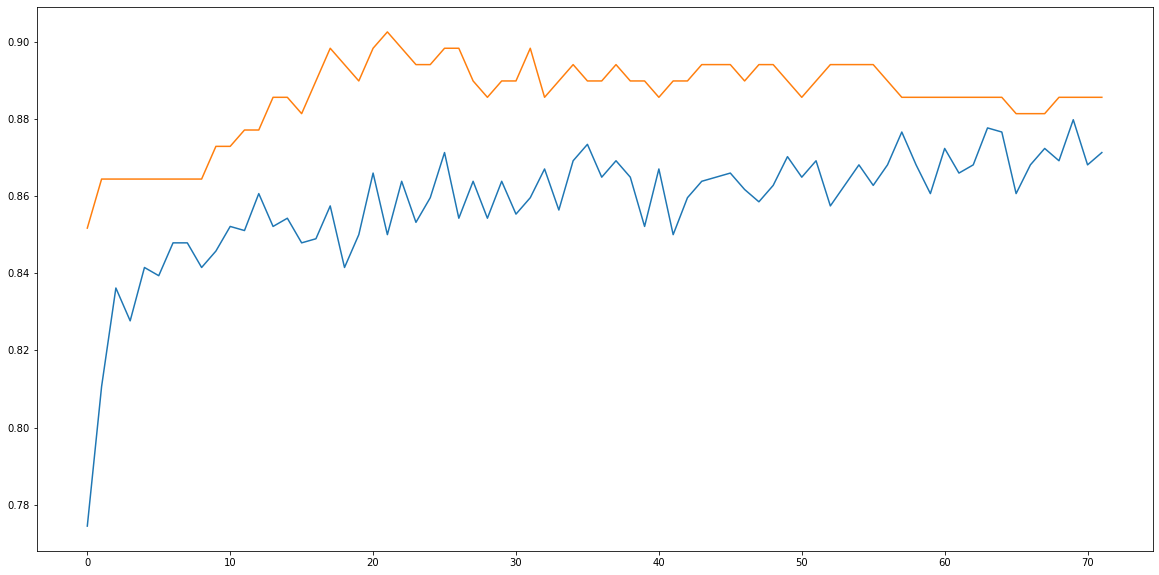

In [1152]:
%%time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=50,monitor = 'val_accuracy')

nn = Sequential()
nn.add(Dense(30,input_dim=(55)))
nn.add(Dropout(0.2))
nn.add(Dropout(0.2))
nn.add(Dense(100))
nn.add(Dense(100))
nn.add(Dense(1,activation='sigmoid'))
nn.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)
model = nn.fit(xtrain,ytrain,epochs=500,validation_split=0.2,batch_size=50,callbacks=es)
model.on_epoch_begin(50)

acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
plt.figure(figsize=(20,10))
plt.plot(acc)
plt.plot(val_acc)

#### So Best Neural Network model is of Minibatch SGD and early stopping. It is faster and more accurate